(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (25600, 806), number for Expceriments: 70
(806,)


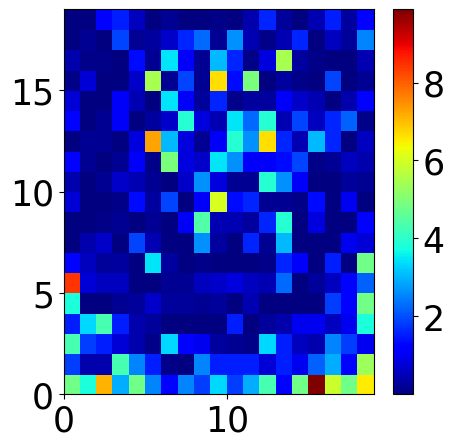

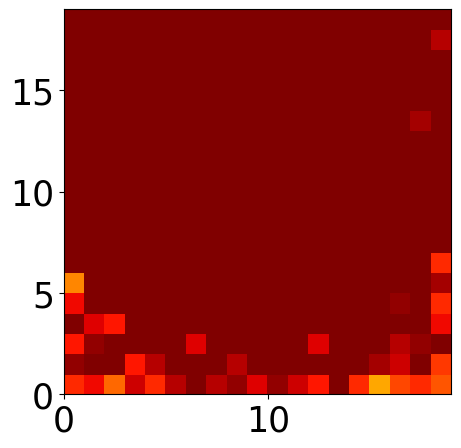

min number of recoveries 44, max number of recoveries 93
(806, 722)
coherence of data:  0.763143828697641
Number of decoder used: 25
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (25600, 806), number for Expceriments: 70
(806,)
Number of recoverd: 722


In [1]:
#IMAGES OF INNER PRODUCTS ACROSS 2 different random media
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform,pdist                                                              
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from sklearn.neighbors import kneighbors_graph
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
import queue
from numpy.linalg import pinv

from numpy import linalg as LA
from scipy.stats import ortho_group
from procrustes import orthogonal
from procrustes import generic


%matplotlib inline

def plot_2_imgs(inners, rho_hat,ind=9,figsize=8,scaling='Linf',font_size=50, Single=False, xpix=31, ypix=21, file_name=None, Lclim=None, Hclim=None):
    plt.close()
    rho_hat_1=np.zeros((2, xpix*ypix))
    rho_hat_1[0, :]=inners[J,:xpix*ypix]
    rho_hat_1=torch.tensor(rho_hat_1)


    
    rho_hat_2=np.zeros((2, xpix*ypix))
    rho_hat_2[0, :]=inners[J,xpix*ypix:]
    #rho=torch.tensor(rho)
    rho_hat_2=torch.tensor(rho_hat_2)




    figsize=(figsize*2,figsize)
    fig, axes=plt.subplots(nrows= 1, ncols= 2,figsize=figsize)
    rhos=[rho_hat_1,rho_hat_2]
    for i in [0,1]:
        rho_hat=rhos[i]
        tick_params = {'labelsize': font_size}
        output=rho_hat.squeeze() 
        output=output[ind,:]
        img=torch.abs((output.squeeze())).view(xpix, ypix)
        ax=axes[i]
        pcol2=ax.pcolor(img.detach().cpu(),cmap='jet')
        cbar=plt.colorbar(pcol2, ax=ax)
    #plt.title('true', fontsize=font_size)
        #ax.set_title('Full model', fontsize=font_size)
        cbar.mappable.set_clim(Lclim, Hclim)
        
        cbar.ax.tick_params(labelsize=font_size)

        #cbar.remove()
        ax.tick_params(axis='both', **tick_params)
        ax.set_xticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
        ax.set_yticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
        
        #if i==0:
        cbar.remove()
    plt.show()

cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

x_list=[5*i for i in range(-4,5)]
y_list=[2*i for i in range(-3,4)]



#NO Gelma KNET=10240
cwd=os.getcwd()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')



medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000

decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/Nogelma_dictsize1024.csv')

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Dict_size=1024*2

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(curr_decoder))

        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=.01

col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
perm=np.random.permutation(X.shape[0])
X=X[perm]
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers, Clustering='DBSCAN'):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in [.01]:
        if Clustering=='DBSCAN':
            DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        else:
            print('OPTICS')
            DBSCAN_fit=OPTICS(min_samples=min_centers, eps=eps,metric='precomputed').fit(torch_inner)
            print('OPTICS ended lmao')
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    if Clustering=='DBSCAN':
                        cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    else:
                        cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-361]-sorted_cluster_sizes[-362])
                next_largest_cluster.append(sorted_cluster_sizes[-362])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-361])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

    return medium_hat_avgs



medium_hat=DBSCAN_inners_fig(col_list, 3, Clustering='DBSCAN')

index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361))**2/(p_hat*(total_num_cols/361)) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=60)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')




#NO Gelma 2 FL reals
cwd=os. getcwd()


def plot_2_imgs(rho, rho_hat,ind=9,figsize=12,scaling='Linf',font_size=50, Single=False, xpix=31, ypix=21, file_name=None, Lclim=None, Hclim=None):
    plt.close()
    if Single:
        figsize=(figsize,figsize)
        fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=figsize)

    else:
        figsize=(figsize,figsize)
        fig, axes=plt.subplots(nrows= 1, ncols= 2,figsize=figsize)

    tick_params = {'labelsize': font_size}
    if not Single:
        output=rho.squeeze()
        ax=axes[0]
        output=output[ind,:]
        if scaling=="Linf":
            output=output/torch.max(torch.abs(cat2complex(output)))
        elif scaling=="L1":
            output=output/torch.sum(torch.abs(cat2complex(output)))
        img=torch.abs(cat2complex(output.squeeze())).view(xpix, ypix)
        pcol1=ax.pcolor(img.detach().cpu(),cmap='jet')
        cbar_used=plt.colorbar(pcol1,ax=ax)

    #plt.title('true', fontsize=font_size)
        cbar_used.ax.tick_params(labelsize=font_size)
        ax.tick_params(axis='both', **tick_params)
        
        #if scaling=="Linf":
        cbar_used.remove()
            


    output=rho_hat.squeeze() 
    output=output[ind,:]
    if scaling=="Linf":

        output=output/torch.max(torch.abs((output)))
    elif scaling=="L1":
        output=output/torch.sum(torch.abs((output)))
    img=torch.abs((output.squeeze())).view(xpix, ypix)
    if not Single:
        ax=axes[1]
    else:
        ax=plt.gca()
    pcol2=ax.pcolor(img.detach().cpu(),cmap='jet')
    cbar=plt.colorbar(pcol2, ax=ax)
#plt.title('true', fontsize=font_size)
    #ax.set_title('Full model', fontsize=font_size)
    if not Single:  
        cbar.mappable.set_clim(*cbar_used.mappable.get_clim())
    elif Lclim!=None:
        cbar.mappable.set_clim(Lclim, Hclim)
        cbar.remove()
    #cbar.remove()
    #ax.tick_params(axis='both', **tick_params)
    ax.set_xticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
    ax.set_yticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
    
    #ax.set_yticks( ticks=[1,4,7,10,13,16,19,22,25,28,31,34,37,], minor=False)
    #cbar.ax.tick_params(labelsize=font_size)
    ax.tick_params(axis='both', **tick_params)

    #ax.tick_params(labelsize=font_size)
    if file_name!=None:
        plt.savefig(file_name)
    plt.show()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium=medium.T
print(medium.shape)

coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000
timescampstrs = [
    "24_09-03-48",
    "23_07-43-10",
    "17_07-42-13",
    "11_07-36-49",
    "5_07-36-03",
    "22_06-21-47",
    "16_06-20-36",
    "10_06-16-03",
    "4_06-15-16",
    "21_05-01-20",
    "15_04-59-52",
    "9_04-55-29",
    "3_04-54-51",
    "20_03-39-41",
    "14_03-38-21",
    "8_03-33-51",
    "2_03-33-27",
    "13_02-14-17",
    "19_02-14-14",
    "7_02-12-32",
    "1_02-12-15",
    "18_00-51-22",
    "12_00-51-08",
    "6_00-50-22",
    "0_00-50-11"
]

decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/2Medium/decoder_5000_'
print(f'Number of decoder used: {len(timescampstrs)}')

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Dict_size=1024*2

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            print(f'failed to load {curr_decoder}')
            continue
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.0001,.03,50)

col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(400):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in [.0025]:
        DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        DBSCAN_fit.labels_
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361*2]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]


            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')

            print(f'Number of recoverd: {len(max_inners_avgs[max_inners_avgs>T_hold])}')

            return medium_hat_avgs

if True:
    for min_centers in [3]:
        medium_hat_double=DBSCAN_inners_fig(col_list, min_centers)
 

In [ ]:
FL=False

if FL:

    data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
    medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
    data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
    medium=np.concatenate((medium1.T, medium2.T), axis=0)
    medium=medium.T

    print(medium.shape)
else:
    data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0')
    medium_list= np.array(mat73.loadmat(data_path+'/rtt_array.mat')['RM_realization_list'])

    medium=np.concatenate((medium_list[:2]), axis=1)

    #data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
    #medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
    #medium=np.concatenate((medium1.T, medium2.T), axis=0)

    print(medium.shape)

    medium=medium.T[:800]
    medium=medium.T
    medium1=medium_list[0]
    medium1=medium1.T

inners=medium.transpose().conjugate()@medium
inners=np.abs(inners)

SINGLE=len(medium1)



J=10*19+10
rho_hat=np.zeros((2, SINGLE))

rho_hat[0, :]=inners[J,:SINGLE]
#rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1




xpix=int(np.sqrt(SINGLE))
ypix=int(np.sqrt(SINGLE))
for J in [10*19+10, 20*10+10]:
    rho_hat=np.zeros((2, SINGLE))

    rho_hat[0, :]=inners[J,:SINGLE]
    #rho=torch.tensor(rho)
    rho_hat=torch.tensor(rho_hat)
    plot_2_imgs(inners, rho_hat,ind=0, figsize=5, scaling=None, xpix=xpix, ypix=ypix, font_size=15, Single=True, Lclim=0, Hclim=1)
rho_hat=np.zeros((2, SINGLE))

#rho_hat[0, :]=inners[J,361:]
#rho=torch.tensor(rho)
#rho_hat=torch.tensor(rho_hat)
#plot_2_imgs(inners, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=1)



In [ ]:
%matplotlib inline
figsize=5

print(medium.shape)
xpix=int(np.sqrt(SINGLE))
ypix=int(np.sqrt(SINGLE))
for J in [10*19+10, 20*10+10]:
    rho_hat=np.zeros((2, SINGLE))

    rho_hat[0, :]=inners[J,:SINGLE]
    #rho=torch.tensor(rho)
    rho_hat=torch.tensor(rho_hat)
    plot_2_imgs(inners, rho_hat,ind=0, figsize=5, scaling=None, xpix=xpix, ypix=ypix, font_size=15, Single=True, Lclim=0, Hclim=1)
rho_hat=np.zeros((2, SINGLE))

In [ ]:
  
font_size=15
Single=True
Lclim=0
Hclim=1
#data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
#medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
#medium=np.concatenate((medium1.T, medium2.T), axis=0)

figsize=(10,5)

medium_1=medium_list[0]
medium_1=medium_1.T
J=10*20+10
ind=0
for i in range(10):
    medium_2=medium_list[i]
    medium_2=medium_2.T
    
    medium=np.concatenate((medium_1, medium_2), axis=0)

    #data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
    #medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
    #medium=np.concatenate((medium1.T, medium2.T), axis=0)
    medium=medium.T
    inners=medium.transpose().conjugate()@medium
    inners=np.abs(inners)  




    plt.close()
    rho_hat_1=np.zeros((2, xpix*ypix))
    rho_hat_1[0, :]=inners[J,:xpix*ypix]
    rho_hat_1=torch.tensor(rho_hat_1)


    
    rho_hat_2=np.zeros((2, xpix*ypix))
    rho_hat_2[0, :]=inners[J,xpix*ypix:]
    #rho=torch.tensor(rho)
    rho_hat_2=torch.tensor(rho_hat_2)




    fig, axes=plt.subplots(nrows= 1, ncols= 2,figsize=figsize)
    rhos=[rho_hat_1,rho_hat_2]
    for i in [0,1]:
        rho_hat=rhos[i]
        tick_params = {'labelsize': font_size}
        output=rho_hat.squeeze() 
        output=output[ind,:]
        img=torch.abs((output.squeeze())).view(xpix, ypix)
        ax=axes[i]
        pcol2=ax.pcolor(img.detach().cpu(),cmap='jet')
        cbar=plt.colorbar(pcol2, ax=ax)
    #plt.title('true', fontsize=font_size)
        #ax.set_title('Full model', fontsize=font_size)
        cbar.mappable.set_clim(Lclim, Hclim)
        
        cbar.ax.tick_params(labelsize=font_size)

        #cbar.remove()
        ax.tick_params(axis='both', **tick_params)
        ax.set_xticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
        ax.set_yticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
        
        #if i==0:
        cbar.remove()
    plt.show()

In [ ]:
figsize

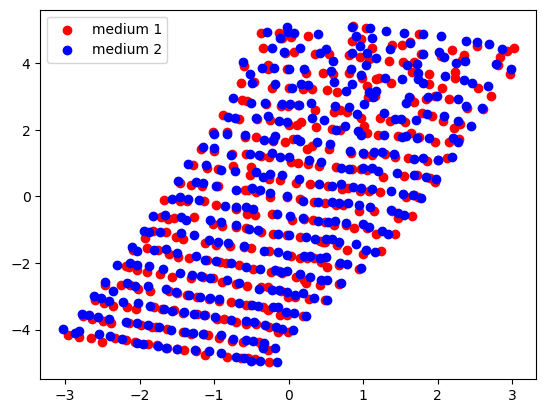

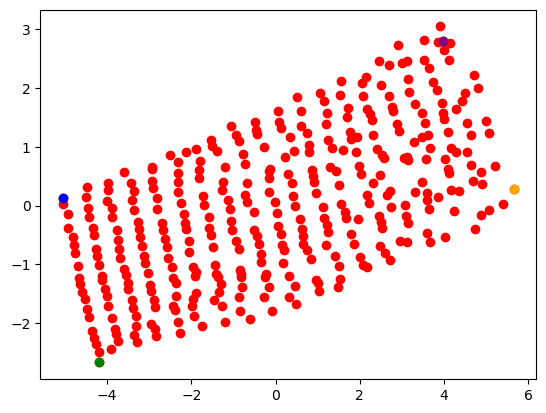

(2, 2) (361,) (361, 2)


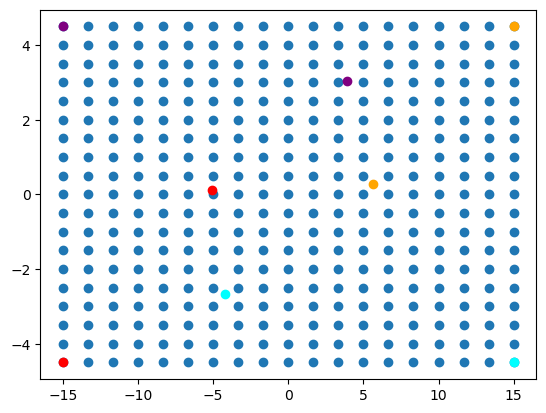

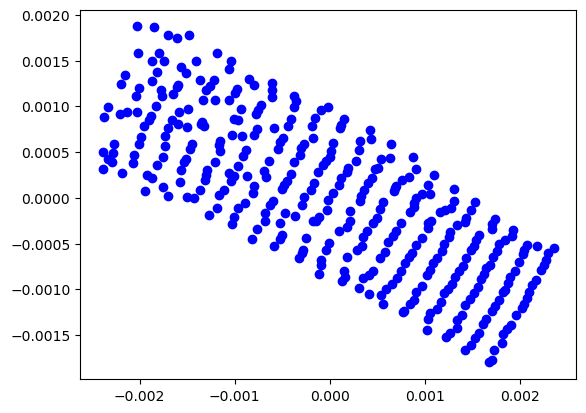

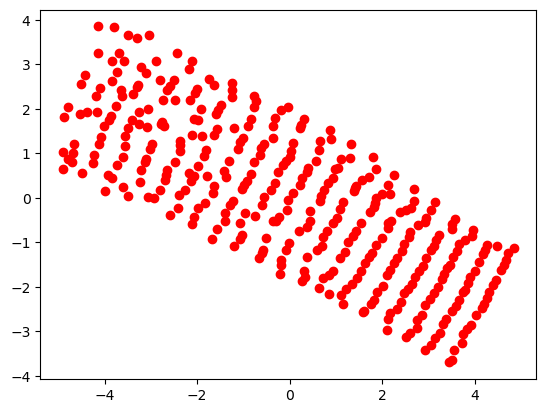

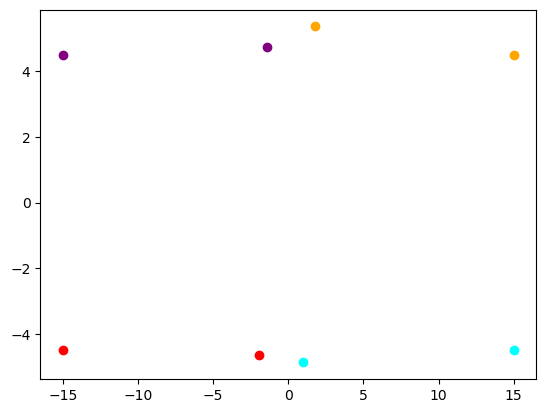

In [53]:

%matplotlib inline
def MDS_plot(medium_1, col_list, Dim=2, n_neighbors=5, Radius=.1, n_neighbors_single=4, EUC=True):
    neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=Radius, metric='precomputed')
    col_perm=np.random.permutation(col_list.shape[0])

    col_list_og=col_list.copy()
    col_list=col_list[col_perm]
    inverse_perm_col=np.argsort(col_perm)



    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    neigh.fit(torch_inner)
    if n_neighbors>1:
        neighbors_dist, neighbors=neigh.kneighbors()
        print(neighbors_dist.shape, neighbors.shape)
    else:
        neighbors_dist, neighbors=neigh.radius_neighbors()
    SINGLE=medium_1.shape[0]
    dist_matrix=np.zeros((len(col_list),len(col_list)))



    for i in range(len(col_list)):
        for j in range(len(neighbors[i])):
            if not EUC:
                dist_matrix[i][neighbors[i][j]]=1
                dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
            else:
                dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
                dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
    A=dist_matrix
    A=shortest_path(A)
    embedding = MDS(n_components=Dim, dissimilarity='precomputed')
    #return A
    X_transformed = embedding.fit_transform(A)

    embedding_medium_1 = MDS(n_components=Dim, dissimilarity='precomputed')
    perm_med1=np.random.permutation(SINGLE)
    inverse_perm_med1=np.argsort(perm_med1)
    OG_medium_1=medium_1.copy()
    medium_1=medium_1[perm_med1]



    torch_inner=np.abs(1.0-(np.abs(np.inner(medium_1,medium_1.conj()))))
    neigh = NearestNeighbors(n_neighbors=n_neighbors_single, radius=Radius, metric='precomputed')
    neigh.fit(torch_inner)
    if n_neighbors>1:
        neighbors_dist, neighbors=neigh.kneighbors()
    else:
        neighbors_dist, neighbors=neigh.radius_neighbors()
    dist_matrix=np.zeros((SINGLE,SINGLE))
    for i in range(SINGLE):
        for j in range(len(neighbors[i])):
            if not EUC:
                dist_matrix[i][neighbors[i][j]]=1
                dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
            else:
                dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
                dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
    A=dist_matrix
    A=shortest_path(A)
    X_transformed_medium_1 = embedding_medium_1.fit_transform(A)


    if Dim==3:
        plt.close()
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        ax.scatter(X_transformed[inverse_perm_col[:SINGLE],0], X_transformed[inverse_perm_col[:SINGLE], 1], X_transformed[inverse_perm_col[:SINGLE],2], c='r')
        ax.scatter(X_transformed[inverse_perm_col[SINGLE:2*SINGLE],0], X_transformed[inverse_perm_col[SINGLE:2*SINGLE],1], X_transformed[inverse_perm_col[SINGLE:SINGLE*2],2], c='b')
        if len(X_transformed>2*SINGLE):
            ax.scatter(X_transformed[inverse_perm_col[2*SINGLE:],0], X_transformed[inverse_perm_col[2*SINGLE:],1], X_transformed[inverse_perm_col[2*SINGLE:],2], c='g')
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
       
        plt.show()
        #fig = plt.figure()
        #ax = fig.add_subplot(projection='3d')

        #ax.scatter(mtx2[inverse_perm[:361],0], mtx2[inverse_perm[:361], 1], mtx2[inverse_perm[:361],2], c='r')
        #ax.scatter(mtx2[361:,0], mtx2[361:,1], mtx2[361:,2], c='b')
        #ax.scatter(mtx1[361:,0], mtx1[361:,1], mtx1[361:,2], c='g')

        #ax.set_xlabel('X Label')
        #ax.set_ylabel('Y Label')
        #ax.set_zlabel('Z Label')
        #plt.show()
        

    else:
        plt.close()

        fig, ax = plt.subplots()
        plt.scatter(X_transformed[inverse_perm_col[:SINGLE],0], X_transformed[inverse_perm_col[:SINGLE], 1], c='r', label='medium 1')
        plt.scatter(X_transformed[inverse_perm_col[SINGLE:2*SINGLE],0], X_transformed[inverse_perm_col[SINGLE:2*SINGLE],1], c='b', label='medium 2')
        plt.legend()
        if len(X_transformed>2*SINGLE):
            plt.scatter(X_transformed[inverse_perm_col[2*SINGLE:],0], X_transformed[inverse_perm_col[2*SINGLE:],1], c='g')
        fig, ax = plt.subplots()
        plt.scatter(X_transformed_medium_1[:,0], X_transformed_medium_1[:,1], c='r')
        plt.scatter(X_transformed_medium_1[inverse_perm_med1[0],0], X_transformed_medium_1[inverse_perm_med1[0], 1], c='blue')

        plt.scatter(X_transformed_medium_1[inverse_perm_med1[19-1],0], X_transformed_medium_1[inverse_perm_med1[19-1], 1], c='green')
        plt.scatter(X_transformed_medium_1[inverse_perm_med1[-1],0], X_transformed_medium_1[inverse_perm_med1[-1], 1], c='orange')
        plt.scatter(X_transformed_medium_1[inverse_perm_med1[-18],0], X_transformed_medium_1[inverse_perm_med1[-18], 1], c='purple')

        #ax[1].scatter(X_transformed_medium_1[inverse_perm_med1,0], X_transformed_medium_1[inverse_perm_med1, 1], c='r')
        #ax[1].scatter(X_transformed_medium_1[inverse_perm_med1,0], X_transformed_medium_1[inverse_perm_med1,1], c='b')

        #ax[2].scatter(X_transformed_medium_2[inverse_perm_med2,0], X_transformed_medium_2[inverse_perm_med2, 1], c='r')

        plt.show()
        fig, ax = plt.subplots()
        x = np.linspace(-15, 15, 19)
        y = np.linspace(-4.50, 4.5, 19)
        xv, yv = np.meshgrid(x, y)
        plt.scatter(xv, yv, label='True grid')
        target_grid=np.zeros((19*19, 2))
        target_grid[:,0]=xv.flatten()
        target_grid[:,1]=yv.flatten()

        mtx1, mtx2, disparity = procrustes(target_grid,X_transformed_medium_1)
        transformation, _=orthogonal_procrustes(X_transformed_medium_1, target_grid)
        print(transformation.shape, inverse_perm_med1.shape, X_transformed_medium_1.shape)


        quarters=X_transformed_medium_1[inverse_perm_med1[[0, 18, 342,360]]]
        quarters_target=target_grid[[0, 18, 342,360]]
        plt.scatter(quarters[0,0], quarters[0,1], c='red')
        plt.scatter(quarters[1,0], quarters[1,1], c='cyan')
        plt.scatter(quarters[2,0], quarters[2,1], c='purple')
        plt.scatter(quarters[3,0], quarters[3,1], c='orange')
        plt.scatter(quarters_target[0,0], quarters_target[0,1], c='red')
        plt.scatter(quarters_target[1,0], quarters_target[1,1], c='cyan')
        plt.scatter(quarters_target[2,0], quarters_target[2,1], c='purple')
        plt.scatter(quarters_target[3,0], quarters_target[3,1], c='orange')
        transformation_corners, _=orthogonal_procrustes(quarters, quarters_target)
        fig, ax = plt.subplots()

        ax.scatter(mtx2[:,0], mtx2[:,1], c='b')
        fig, ax = plt.subplots()
        reshaped=(X_transformed_medium_1@transformation)
        ax.scatter((reshaped)[:,0], (reshaped)[:,1], c='r')
        fig, ax = plt.subplots()
        reshaped=(quarters@transformation_corners)
        #ax.scatter((reshaped)[:,0], (reshaped)[:,1], c='r')
        plt.scatter(reshaped[0,0], reshaped[0,1], c='red')
        plt.scatter(reshaped[1,0], reshaped[1,1], c='cyan')
        plt.scatter(reshaped[2,0], reshaped[2,1], c='purple')
        plt.scatter(reshaped[3,0], reshaped[3,1], c='orange')
        plt.scatter(quarters_target[0,0], quarters_target[0,1], c='red')
        plt.scatter(quarters_target[1,0], quarters_target[1,1], c='cyan')
        plt.scatter(quarters_target[2,0], quarters_target[2,1], c='purple')
        plt.scatter(quarters_target[3,0], quarters_target[3,1], c='orange')

    return X_transformed_medium_1






#medium=np.concatenate((medium_list[:2]), axis=1)

#data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
#medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
#medium=np.concatenate((medium1.T, medium2.T), axis=0)

if False:
    data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0')
    medium_list= np.array(mat73.loadmat(data_path+'/rtt_array.mat')['RM_realization_list'])

    medium=medium.T[:800]
    medium=medium.T
    medium1=medium_list[0] 
    medium1=medium1.T
            

#col_list=np.concatenate((medium_list[:15]), axis=1)
    col_list=col_list.T
    print(col_list.shape, medium_1.shape)    


data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T
col_list=medium
T=MDS_plot(medium1, col_list, Dim=2, n_neighbors=1,Radius=.75, n_neighbors_single=4 ,EUC=False)





(722, 806) (361, 806) (806, 361)


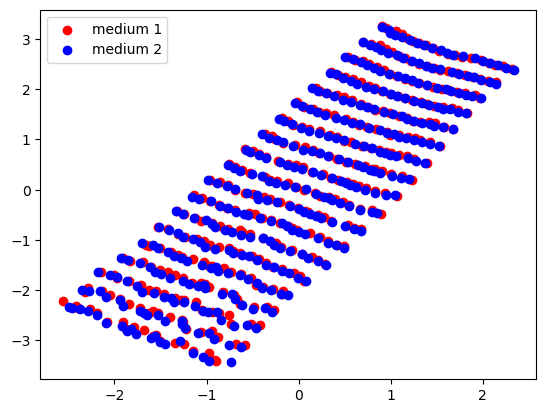

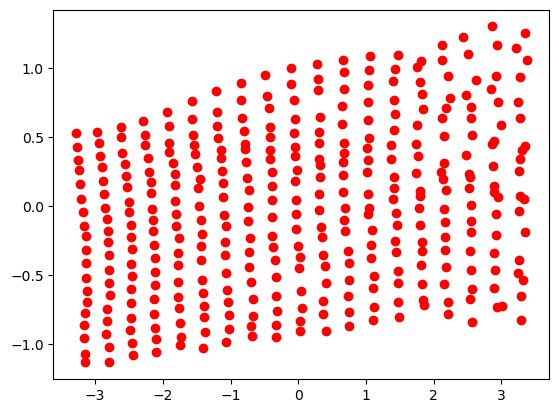

In [60]:
X_transformed_medium_1



In [49]:
%matplotlib inline
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium=medium
medium1=medium1.T

print(medium.shape, medium1.shape, medium2.shape)


MDS_plot(medium1, medium, Dim=2, n_neighbors=1,Radius=.75, n_neighbors_single=4 ,EUC=False)




(722, 806) (361, 806) (806, 361)


TypeError: MDS_plot() got an unexpected keyword argument 'n_neighbors'

(361, 806) (722, 806)
(361, 361)
coherence of sepmed1:  0.7847237581880193
coherence of sepmed2:  0.7847237581880193
coherence of full:  0.7847237581880193
0
(361, 806) (361, 806)
Number of points from medium 1: 180, number of points from medium 2: 181


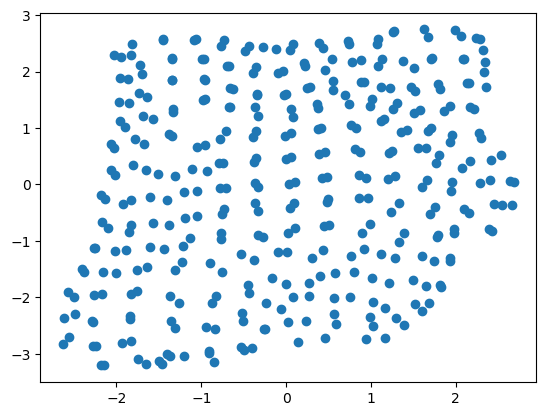

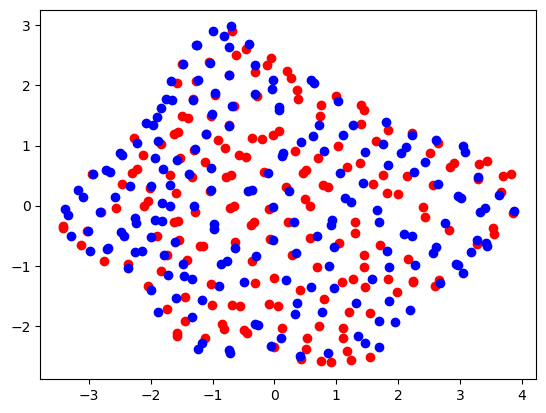

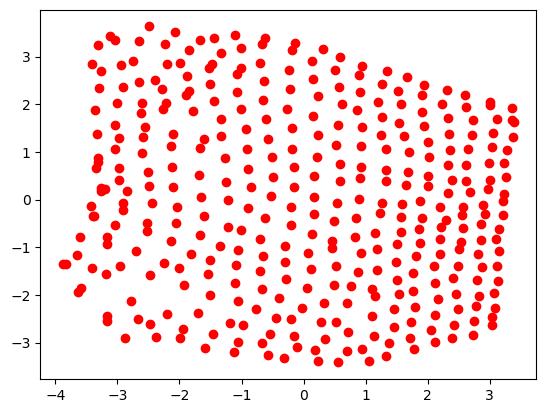

In [78]:
#George's algo. Currently theres a bug and its not working. He said to leave it since the other method is working
#Select 1. Find 'best'. Move to the other one. Find next best 4. move to 1 neighbor. Move best to other graph. continue.
def MDS_plot_sep(medium_1, col_list, Dim=2, Radius=.1, n_neighbors_single=4, EUC=True):
    n_neighbors=n_neighbors_single
    col_perm=np.random.permutation(col_list.shape[0])

    col_list_og=copy.deepcopy(col_list)
    #col_list=col_list[col_perm]
    #inverse_perm_col=np.argsort(col_perm)
    New_col_list=[]
    neighbors_dist=[]
    neighbors=[]

    curr_col_list_index=0
    Un_processed_neighs=queue.Queue()
    other_medium=[]
    processed_=[0]*len(col_list)
    med_in_new2=[]
    while len(New_col_list)<int(len(col_list)/2):
        if not Un_processed_neighs.empty():
            curr_g=Un_processed_neighs.get()
        else:
            curr_g=col_list[curr_col_list_index]
            processed_[curr_col_list_index]=1
            curr_col_list_index+=1
            if sum(curr_g)==0:
                continue
        torch_inner=np.abs(1.0-(np.abs(np.inner(curr_g,col_list.conj()))))

        #arr.argsort()[:n]
        ind = np.argpartition(torch_inner, n_neighbors)[:n_neighbors]
        ind=ind[np.argsort(torch_inner[ind])]
        #print(len(ind))
        other_medium.append(copy.deepcopy(col_list[ind[0]]))
        if ind[-1]>=361:
            med_in_new2.append(1)
        else:
            med_in_new2.append(0)
        New_col_list.append(copy.deepcopy(curr_g))
        col_list[ind[0]]=0*col_list[ind[0]]
        for i in range(1, n_neighbors):
            if processed_[ind[i]]==0:
                Un_processed_neighs.put(col_list[ind[i]])
                processed_[ind[i]]=1
                
        
    New_col_list=np.array(New_col_list)
    New_col_list_inners=New_col_list@New_col_list.transpose().conjugate()
    New_col_list_inners=np.abs(New_col_list_inners)
    other_medium=np.array(other_medium)
    other_medium_inners=other_medium@other_medium.transpose().conjugate()
    other_medium_inners=np.abs(other_medium_inners)

    full_inners=col_list_og@col_list_og.transpose().conjugate()
    full_inners=np.abs(full_inners)

    coherence1=0
    for i in New_col_list_inners:
        for j in i:
            if abs(j)>coherence1 and j<.99:
                coherence1=abs(j)
    print(New_col_list_inners.shape)
    print('coherence of sepmed1: ', coherence1)
    coherence2=0
    for i in other_medium_inners:
        for j in i:
            if abs(j)>coherence2 and j<.99:
                coherence2=abs(j)
    print('coherence of sepmed2: ', coherence2)
    coherence=0
    for i in full_inners:
        for j in i:
            if abs(j)>coherence and j<.99:
                coherence=abs(j)
    print('coherence of full: ', coherence)

    mistake_counter=0
    for i in New_col_list:
        if sum(i)==0:
            mistake_counter+=1
    print(mistake_counter)
    print(New_col_list.shape, other_medium.shape)
    #'Separeted' medium 1
    torch_inner_med1=np.abs(1.0-(np.abs(np.inner(New_col_list,New_col_list.conj()))))
    neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=Radius, metric='precomputed')
    neigh.fit(torch_inner_med1)
    neighbors_dist, neighbors=neigh.kneighbors()
    SINGLE=medium_1.shape[0]
    dist_matrix=np.zeros((len(New_col_list),len(New_col_list)))
    for i in range(len(New_col_list)):
        for j in range(len(neighbors[i])):
            if not EUC:
                dist_matrix[i][neighbors[i][j]]=1
                dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
            else:
                dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
                dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
    A=dist_matrix
    A=shortest_path(A)
    embedding = MDS(n_components=Dim, dissimilarity='precomputed')
    #return A
    X_transformed_sepmed1 = embedding.fit_transform(A)





    

    #'Separeted' medium 1
    torch_inner_med2=np.abs(1.0-(np.abs(np.inner(other_medium,other_medium.conj()))))
    neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=Radius, metric='precomputed')
    neigh.fit(torch_inner_med2)
    neighbors_dist, neighbors=neigh.kneighbors()
    dist_matrix=np.zeros((len(other_medium),len(other_medium)))
    for i in range(len(other_medium)):
        for j in range(len(neighbors[i])):
            if not EUC:
                dist_matrix[i][neighbors[i][j]]=1
                dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
            else:
                dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
                dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
    A=dist_matrix
    A=shortest_path(A)
    embedding = MDS(n_components=Dim, dissimilarity='precomputed')
    #return A
    X_transformed_sepmed2 = embedding.fit_transform(A)

    col_list=col_list_og.copy()
    embedding_medium_1 = MDS(n_components=Dim, dissimilarity='precomputed')
    perm_med1=np.random.permutation(SINGLE)
    inverse_perm_med1=np.argsort(perm_med1)
    OG_medium_1=medium_1.copy()
    medium_1=medium_1[perm_med1]
    torch_inner=np.abs(1.0-(np.abs(np.inner(medium_1,medium_1.conj()))))
    neigh = NearestNeighbors(n_neighbors=n_neighbors_single, radius=Radius, metric='precomputed')
    neigh.fit(torch_inner)
    if n_neighbors>1:
        neighbors_dist, neighbors=neigh.kneighbors()
    else:
        neighbors_dist, neighbors=neigh.radius_neighbors()
    dist_matrix=np.zeros((SINGLE,SINGLE))
    for i in range(SINGLE):
        for j in range(len(neighbors[i])):
            if not EUC:
                dist_matrix[i][neighbors[i][j]]=1
                dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
            else:
                dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
                dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
    A=dist_matrix
    A=shortest_path(A)
    X_transformed_medium_1 = embedding_medium_1.fit_transform(A)
    med_in_new2=np.array(med_in_new2)

    plt.close()
    fig, ax = plt.subplots()
    plt.scatter(X_transformed_sepmed1[:,0], X_transformed_sepmed1[:, 1])
    fig, ax = plt.subplots()
    plt.scatter(X_transformed_sepmed2[med_in_new2==0,0], X_transformed_sepmed2[med_in_new2==0,1], c='r')
    plt.scatter(X_transformed_sepmed2[med_in_new2==1,0], X_transformed_sepmed2[med_in_new2==1,1], c='b')
    print(f'Number of points from medium 1: {sum(med_in_new2==0)}, number of points from medium 2: {sum(med_in_new2==1)}')

    fig, ax = plt.subplots()
    plt.scatter(X_transformed_medium_1[:,0], X_transformed_medium_1[:,1], c='r')
    plt.show()


data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium=medium
medium1=medium1.T

print(medium1.shape, medium.shape)        
MDS_plot_sep(medium1, medium, Dim=2,Radius=.75, n_neighbors_single=5 ,EUC=True)


In [38]:

Un_processed_neighs=queue.Queue()
Un_processed_neighs.put(1)
Un_processed_neighs.put(2)


In [29]:
while 
    print(Un_processed_neighs.get())


1
2


In [26]:
Un_processed_neighs.get()dddd

KeyboardInterrupt: 

In [54]:
dummy=np.random.randn(50,4)
dummy_perm=np.random.permutation(dummy.shape[0])
dummy_permed=dummy[dummy_perm]
inverse_perm_col=np.argsort(dummy_perm)
permer=np.argsort(inverse_perm_col)
np.allclose(dummy, dummy_permed[inverse_perm_col]), np.allclose(dummy_permed, dummy[(permer)])


(True, True)

(361, 806) (361, 806)
(722, 5) (722, 5)
average number of neighbors in double case: 5.753462603878116
average number of neighbors in single case: 4.664819944598338


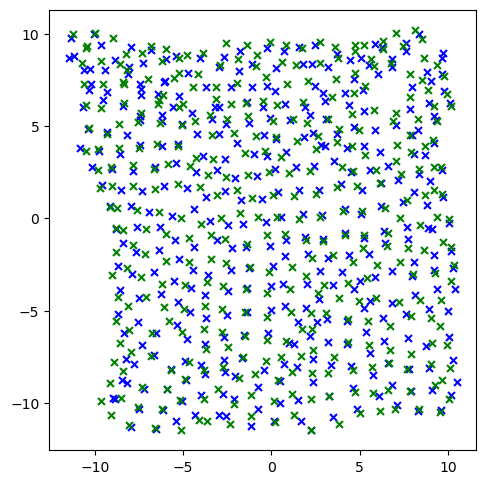

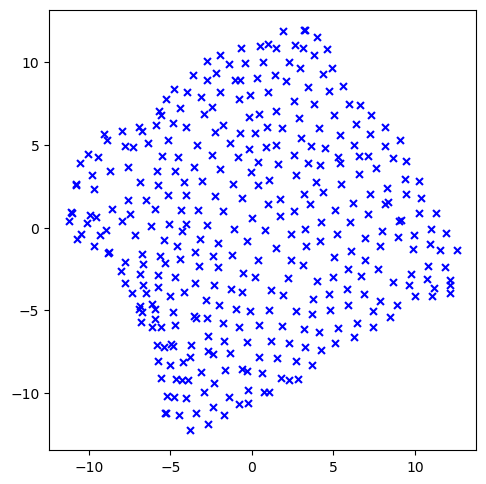

(722, 806) (721, 806)
(721, 5) (721, 5)
average number of neighbors in double case: 5.775312066574203
average number of neighbors in single case: 4.6814404432132966


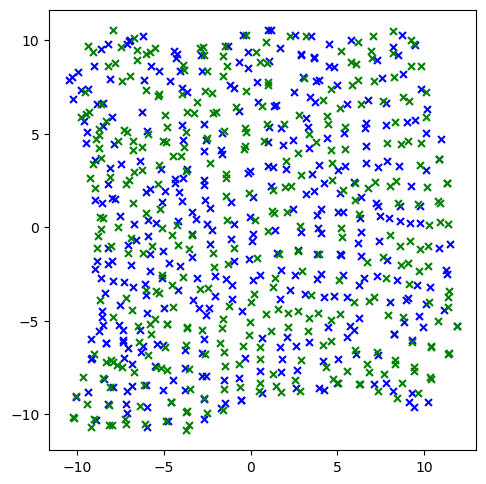

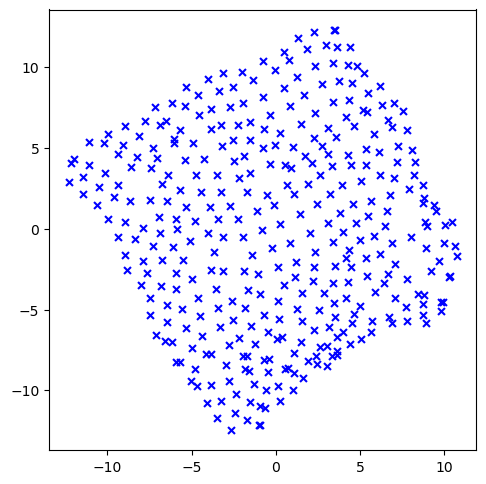

In [7]:
%matplotlib inline
def MDS_plot(medium_1, col_list, Dim=2, n_neighbors=5, Radius=.1, n_neighbors_single=4, EUC=True):
    neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=Radius, metric='precomputed')
    col_perm=np.random.permutation(col_list.shape[0])

    col_list_og=col_list.copy()
    col_list=col_list[col_perm]
    inverse_perm_col=np.argsort(col_perm)



    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    neigh.fit(torch_inner)
    if n_neighbors>1:
        neighbors_dist, neighbors=neigh.kneighbors()
        print(neighbors_dist.shape, neighbors.shape)
    else:
        neighbors_dist, neighbors=neigh.radius_neighbors()
    SINGLE=medium_1.shape[0]
    dist_matrix=np.zeros((len(col_list),len(col_list)))



    for i in range(len(col_list)):
        for j in range(len(neighbors[i])):
            if not EUC:
                dist_matrix[i][neighbors[i][j]]=1
                dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
            else:
                dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
                dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
    A=dist_matrix
    avg_neighbors=sum([len(A[i][A[i]>0]) for i in range(len(col_list))])/len(col_list)
    print(f'average number of neighbors in double case: {avg_neighbors}')
    A=shortest_path(A)
    embedding = MDS(n_components=Dim, dissimilarity='precomputed')
    #return A
    X_transformed = embedding.fit_transform(A)

    embedding_medium_1 = MDS(n_components=Dim, dissimilarity='precomputed')
    perm_med1=np.random.permutation(SINGLE)
    inverse_perm_med1=np.argsort(perm_med1)
    OG_medium_1=medium_1.copy()
    medium_1=medium_1[perm_med1]



    torch_inner=np.abs(1.0-(np.abs(np.inner(medium_1,medium_1.conj()))))
    neigh = NearestNeighbors(n_neighbors=n_neighbors_single, radius=Radius, metric='precomputed')
    neigh.fit(torch_inner)
    if n_neighbors>1:
        neighbors_dist, neighbors=neigh.kneighbors()
    else:
        neighbors_dist, neighbors=neigh.radius_neighbors()
    dist_matrix=np.zeros((SINGLE,SINGLE))
    for i in range(SINGLE):
        for j in range(len(neighbors[i])):
            if not EUC:
                dist_matrix[i][neighbors[i][j]]=1
                dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
            else:
                dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
                dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
    A=dist_matrix
    avg_neighbors=sum([len(A[i][A[i]>0]) for i in range(SINGLE)])/SINGLE
    print(f'average number of neighbors in single case: {avg_neighbors}')
    A=shortest_path(A)
    X_transformed_medium_1 = embedding_medium_1.fit_transform(A)


    if Dim==3:
        plt.close()
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        ax.scatter(X_transformed[inverse_perm_col[:SINGLE],0], X_transformed[inverse_perm_col[:SINGLE], 1], X_transformed[inverse_perm_col[:SINGLE],2], c='r')
        ax.scatter(X_transformed[inverse_perm_col[SINGLE:2*SINGLE],0], X_transformed[inverse_perm_col[SINGLE:2*SINGLE],1], X_transformed[inverse_perm_col[SINGLE:SINGLE*2],2], c='b')
        if len(X_transformed>2*SINGLE):
            ax.scatter(X_transformed[inverse_perm_col[2*SINGLE:],0], X_transformed[inverse_perm_col[2*SINGLE:],1], X_transformed[inverse_perm_col[2*SINGLE:],2], c='g')
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
       
        plt.show()
        #fig = plt.figure()
        #ax = fig.add_subplot(projection='3d')

        #ax.scatter(mtx2[inverse_perm[:361],0], mtx2[inverse_perm[:361], 1], mtx2[inverse_perm[:361],2], c='r')
        #ax.scatter(mtx2[361:,0], mtx2[361:,1], mtx2[361:,2], c='b')
        #ax.scatter(mtx1[361:,0], mtx1[361:,1], mtx1[361:,2], c='g')

        #ax.set_xlabel('X Label')
        #ax.set_ylabel('Y Label')
        #ax.set_zlabel('Z Label')
        #plt.show()
        

    else:
        plt.close()

        fig, ax = plt.subplots(figsize=(5,5))
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()

        plt.scatter(X_transformed[inverse_perm_col[:SINGLE],0], X_transformed[inverse_perm_col[:SINGLE], 1], c='b', s=25,marker='x')
        plt.scatter(X_transformed[inverse_perm_col[SINGLE:2*SINGLE],0], X_transformed[inverse_perm_col[SINGLE:2*SINGLE],1], c='g',  s=25,marker='x')
        #plt.title('2mediums')
        if len(X_transformed>2*SINGLE):
            plt.scatter(X_transformed[inverse_perm_col[2*SINGLE:],0], X_transformed[inverse_perm_col[2*SINGLE:],1], c='g')
        fig, ax = plt.subplots(figsize=(5,5))
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()


        #plt.title('1medium')
        plt.scatter(X_transformed_medium_1[:,0], X_transformed_medium_1[:,1], c='b', s=25,marker='x')

      #  plt.scatter(X_transformed_medium_1[inverse_perm_med1[0],0], X_transformed_medium_1[inverse_perm_med1[0], 1], c='red')

        #plt.scatter(X_transformed_medium_1[inverse_perm_med1[19-1],0], X_transformed_medium_1[inverse_perm_med1[19-1], 1], c='green')
        #plt.scatter(X_transformed_medium_1[inverse_perm_med1[-18],0], X_transformed_medium_1[inverse_perm_med1[-18], 1], c='purple')
        #plt.scatter(X_transformed_medium_1[inverse_perm_med1[-1],0], X_transformed_medium_1[inverse_perm_med1[-1], 1], c='orange')

        #ax[1].scatter(X_transformed_medium_1[inverse_perm_med1,0], X_transformed_medium_1[inverse_perm_med1, 1], c='r')
        #ax[1].scatter(X_transformed_medium_1[inverse_perm_med1,0], X_transformed_medium_1[inverse_perm_med1,1], c='b')

        #ax[2].scatter(X_transformed_medium_2[inverse_perm_med2,0], X_transformed_medium_2[inverse_perm_med2, 1], c='r')

        plt.show()

       
    return X_transformed_medium_1, inverse_perm_med1, X_transformed, inverse_perm_col






#medium=np.concatenate((medium_list[:2]), axis=1)

#data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
#medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
#medium=np.concatenate((medium1.T, medium2.T), axis=0)

if False:
    data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0')
    medium_list= np.array(mat73.loadmat(data_path+'/rtt_array.mat')['RM_realization_list'])

    medium=medium.T[:800]
    medium=medium.T
    medium1=medium_list[0] 
    medium1=medium1.T
            

#col_list=np.concatenate((medium_list[:15]), axis=1)
    col_list=col_list.T
    print(col_list.shape, medium_1.shape)    


data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T
col_list=medium
print(medium1.shape, medium_hat.shape)
single, single_true_labeling, double, double_true_labeleing=MDS_plot(medium1, col_list, Dim=2, n_neighbors=5,Radius=.7, n_neighbors_single=4 ,EUC=False)
print(col_list.shape, medium_hat_double.shape)
single_estimated, single_estimated_true_lab, double_estimated, double_estimated_true_lab=MDS_plot(medium_hat, medium_hat_double, Dim=2, n_neighbors=5,Radius=.7, n_neighbors_single=4 ,EUC=False)



In [1]:
%matplotlib inline
def MDS_plot(medium_1, col_list, Dim=2, n_neighbors=5, Radius=.1, n_neighbors_single=4, EUC=True):
    neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=Radius, metric='precomputed')
    col_perm=np.random.permutation(col_list.shape[0])

    col_list_og=col_list.copy()
    col_list=col_list[col_perm]
    inverse_perm_col=np.argsort(col_perm)



    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    neigh.fit(torch_inner)
    if n_neighbors>1:
        neighbors_dist, neighbors=neigh.kneighbors()
        print(neighbors_dist.shape, neighbors.shape)
    else:
        neighbors_dist, neighbors=neigh.radius_neighbors()
    SINGLE=medium_1.shape[0]
    dist_matrix=np.zeros((len(col_list),len(col_list)))



    for i in range(len(col_list)):
        for j in range(len(neighbors[i])):
            if not EUC:
                dist_matrix[i][neighbors[i][j]]=1
                dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
            else:
                dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
                dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
    A=dist_matrix
    avg_neighbors=sum([len(A[i][A[i]>0]) for i in range(len(col_list))])/len(col_list)
    print(f'average number of neighbors in double case: {avg_neighbors}')
    A=shortest_path(A)
    embedding = MDS(n_components=Dim, dissimilarity='precomputed')
    #return A
    X_transformed = embedding.fit_transform(A)

    embedding_medium_1 = MDS(n_components=Dim, dissimilarity='precomputed')
    perm_med1=np.random.permutation(SINGLE)
    inverse_perm_med1=np.argsort(perm_med1)
    OG_medium_1=medium_1.copy()
    medium_1=medium_1[perm_med1]



    torch_inner=np.abs(1.0-(np.abs(np.inner(medium_1,medium_1.conj()))))
    neigh = NearestNeighbors(n_neighbors=n_neighbors_single, radius=Radius, metric='precomputed')
    neigh.fit(torch_inner)
    if n_neighbors>1:
        neighbors_dist, neighbors=neigh.kneighbors()
    else:
        neighbors_dist, neighbors=neigh.radius_neighbors()
    dist_matrix=np.zeros((SINGLE,SINGLE))
    for i in range(SINGLE):
        for j in range(len(neighbors[i])):
            if not EUC:
                dist_matrix[i][neighbors[i][j]]=1
                dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
            else:
                dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
                dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
    A=dist_matrix
    avg_neighbors=sum([len(A[i][A[i]>0]) for i in range(SINGLE)])/SINGLE
    print(f'average number of neighbors in single case: {avg_neighbors}')
    A=shortest_path(A)
    X_transformed_medium_1 = embedding_medium_1.fit_transform(A)


    if Dim==3:
        plt.close()
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        ax.scatter(X_transformed[inverse_perm_col[:SINGLE],0], X_transformed[inverse_perm_col[:SINGLE], 1], X_transformed[inverse_perm_col[:SINGLE],2], c='r')
        ax.scatter(X_transformed[inverse_perm_col[SINGLE:2*SINGLE],0], X_transformed[inverse_perm_col[SINGLE:2*SINGLE],1], X_transformed[inverse_perm_col[SINGLE:SINGLE*2],2], c='b')
        if len(X_transformed>2*SINGLE):
            ax.scatter(X_transformed[inverse_perm_col[2*SINGLE:],0], X_transformed[inverse_perm_col[2*SINGLE:],1], X_transformed[inverse_perm_col[2*SINGLE:],2], c='g')
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
       
        plt.show()
        #fig = plt.figure()
        #ax = fig.add_subplot(projection='3d')

        #ax.scatter(mtx2[inverse_perm[:361],0], mtx2[inverse_perm[:361], 1], mtx2[inverse_perm[:361],2], c='r')
        #ax.scatter(mtx2[361:,0], mtx2[361:,1], mtx2[361:,2], c='b')
        #ax.scatter(mtx1[361:,0], mtx1[361:,1], mtx1[361:,2], c='g')

        #ax.set_xlabel('X Label')
        #ax.set_ylabel('Y Label')
        #ax.set_zlabel('Z Label')
        #plt.show()
        

    else:
        plt.close()

        fig, ax = plt.subplots(figsize=(5,5))
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()

        plt.scatter(X_transformed[inverse_perm_col[:SINGLE],0], X_transformed[inverse_perm_col[:SINGLE], 1], c='b', s=25,marker='x')
        plt.scatter(X_transformed[inverse_perm_col[SINGLE:2*SINGLE],0], X_transformed[inverse_perm_col[SINGLE:2*SINGLE],1], c='g',  s=25,marker='x')
        #plt.title('2mediums')
        if len(X_transformed>2*SINGLE):
            plt.scatter(X_transformed[inverse_perm_col[2*SINGLE:],0], X_transformed[inverse_perm_col[2*SINGLE:],1], c='g')
        fig, ax = plt.subplots(figsize=(5,5))
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()


        #plt.title('1medium')
        plt.scatter(X_transformed_medium_1[:,0], X_transformed_medium_1[:,1], c='b', s=25,marker='x')

      #  plt.scatter(X_transformed_medium_1[inverse_perm_med1[0],0], X_transformed_medium_1[inverse_perm_med1[0], 1], c='red')

        #plt.scatter(X_transformed_medium_1[inverse_perm_med1[19-1],0], X_transformed_medium_1[inverse_perm_med1[19-1], 1], c='green')
        #plt.scatter(X_transformed_medium_1[inverse_perm_med1[-18],0], X_transformed_medium_1[inverse_perm_med1[-18], 1], c='purple')
        #plt.scatter(X_transformed_medium_1[inverse_perm_med1[-1],0], X_transformed_medium_1[inverse_perm_med1[-1], 1], c='orange')

        #ax[1].scatter(X_transformed_medium_1[inverse_perm_med1,0], X_transformed_medium_1[inverse_perm_med1, 1], c='r')
        #ax[1].scatter(X_transformed_medium_1[inverse_perm_med1,0], X_transformed_medium_1[inverse_perm_med1,1], c='b')

        #ax[2].scatter(X_transformed_medium_2[inverse_perm_med2,0], X_transformed_medium_2[inverse_perm_med2, 1], c='r')

        plt.show()

       
    return X_transformed_medium_1, inverse_perm_med1, X_transformed, inverse_perm_col






#medium=np.concatenate((medium_list[:2]), axis=1)

#data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
#medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
#medium=np.concatenate((medium1.T, medium2.T), axis=0)

if False:
    data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0')
    medium_list= np.array(mat73.loadmat(data_path+'/rtt_array.mat')['RM_realization_list'])

    medium=medium.T[:800]
    medium=medium.T
    medium1=medium_list[0] 
    medium1=medium1.T
            

#col_list=np.concatenate((medium_list[:15]), axis=1)
    col_list=col_list.T
    print(col_list.shape, medium_1.shape)    


data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T
col_list=medium
print(medium1.shape, medium_hat.shape)
single, single_true_labeling, double, double_true_labeleing=MDS_plot(medium1, col_list, Dim=2, n_neighbors=3,Radius=.65, n_neighbors_single=4 ,EUC=True)
print(col_list.shape, medium_hat_double.shape)
single_estimated, single_estimated_true_lab, double_estimated, double_estimated_true_lab=MDS_plot(medium_hat, medium_hat_double, Dim=2, n_neighbors=1,Radius=.65, n_neighbors_single=4 ,EUC=True)



NameError: name 'os' is not defined

Error from grid recon using perf grid 0.07142193895838196
Error from grid recon using imperfect grid 0.06305281629214873
Medium: (806, 361), Rho: (1, 361), B: (1, 806)
(361, 806)
rho, b shape: (1, 361), (1, 806)
[0.00794626 0.00798546 0.99909208 1.00000067 1.00000604 2.42041937]
[0.77847534 0.7805466  0.7819095  0.83249698 0.8904413  2.38681988]
[ 98401.8191631  103508.53116938 103794.41048214 109508.97554751
 112695.66773912 113487.70000995]
[ 98401.8191631  103508.53116938 103794.41048214 109508.97554751
 112695.66773912 113487.70000995]


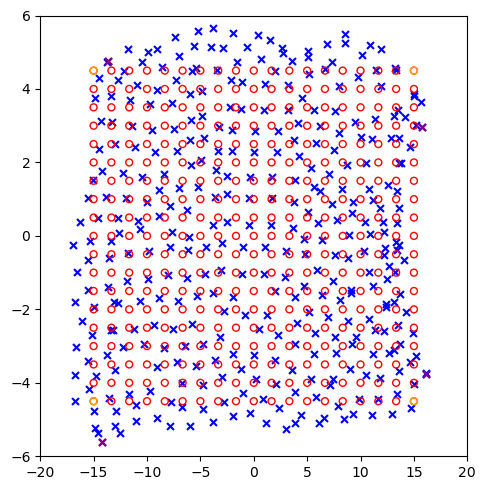

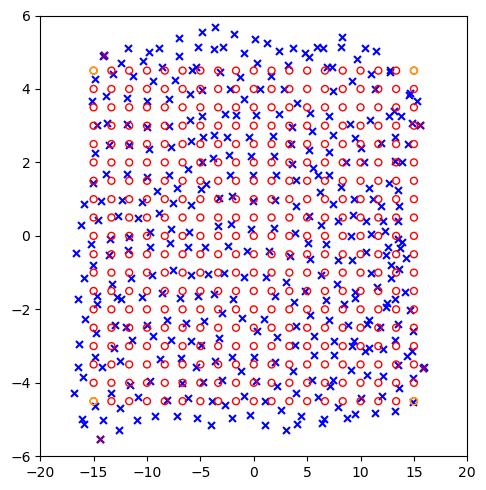

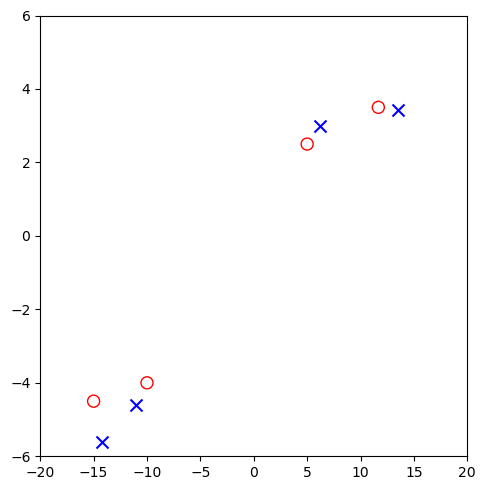

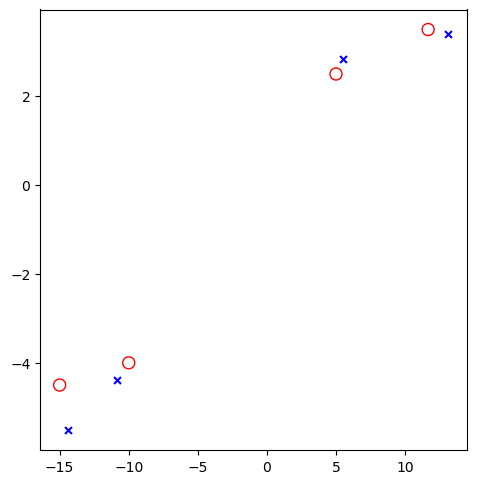

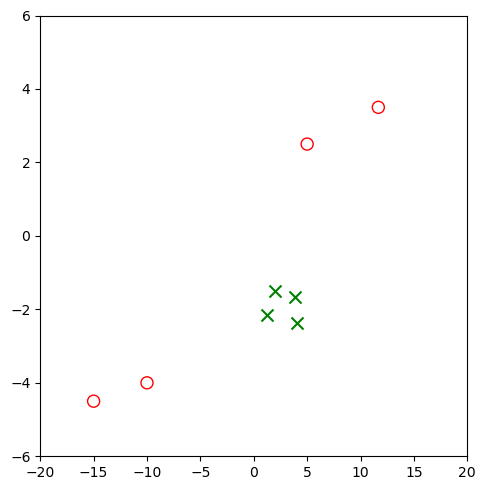

In [8]:
def repostition_grid(hat, target, corner_indices, CORNERS=True, Save=False):
    #plt.close()
    hat_corners=hat[corner_indices]
    targ_corners=target[[0, 18, 342,360]]
    
    if CORNERS:
        targ_translation=np.mean(targ_corners, axis=0)
        targ_scale=LA.norm(targ_corners-targ_translation, ord='fro')


        hat_translation=np.mean(hat_corners, axis=0)
        hat_scale=LA.norm(hat_corners-hat_translation, ord='fro')
    else:
        targ_translation=np.mean(target, axis=0)
        targ_scale=LA.norm(target-targ_translation, ord='fro')
        hat_translation=np.mean(hat, axis=0)
        hat_scale=LA.norm(hat-hat_translation, ord='fro')

    

    

    targ_standardized=(target-targ_translation)/targ_scale
    hat_standardized=(hat-hat_translation)/hat_scale

    targ_corners=targ_standardized[[0, 18, 342,360]]
    hat_corners=hat_standardized[corner_indices]
#    print(f'the column means are: {np.mean(targ_standardized, axis=0)}')

    result = generic(hat_corners, targ_corners, scale=False, translate=False)

    transformation=result.t
    x_scale=min(abs(targ_corners[:,0]))
    trans_2=np.array([[1.2,0],[0,1/2.5]])
    
    new_grid=(hat_standardized@transformation)*targ_scale#+targ_translation
    fig, ax = plt.subplots(figsize=(5,5))
    
    plt.tight_layout()
    plt.scatter(new_grid[:,0], new_grid[:,1], c='b', label='grid hat', s=25,marker='x')
    plt.scatter(target[:,0], target[:,1], facecolors='none', edgecolors='r', label='grid target', s=25)

    plt.scatter(target[[0,18,342,360],0], target[[0,18,342,360],1], edgecolors='orange', facecolors='none', s=25)

    plt.scatter(new_grid[corner_indices,0], new_grid[corner_indices,1], c='purple',s=25, marker='x')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xticks(ticks=x_list,fontsize=10)
    plt.yticks(ticks=y_list,fontsize=10)
    plt.axis([x_list[0],x_list[-1], y_list[0], y_list[-1]])
    if Save:
        plt.savefig('/home/achristie/Codes_data/Experiment_data/library_learning/single_medium_MDS.pdf')

    return new_grid
    



    

y = np.linspace(-15, 15, 19)
x = np.linspace(-4.50, 4.5, 19)
yv, xv = np.meshgrid(x, y)
#plt.scatter(xv, yv, label='True grid')
target_grid=np.zeros((19*19, 2))
target_grid[:,0]=xv.flatten()
target_grid[:,1]=yv.flatten()


New_grid=repostition_grid(single, target_grid, single_true_labeling[[0, 18, 342,360]], CORNERS=False, Save=True)
error=LA.norm(New_grid[single_true_labeling]-target_grid, ord='fro')/len(New_grid)
print(f'Error from grid recon using perf grid {error}')


True_corners=[0, 18, 342,360]


Estimated_corners_indices=np.abs((np.abs(np.inner(medium1[True_corners],medium_hat.conj()))))
Estimated_corners_indices_=[np.argmax(Estimated_corners_indices[i,:]) for i in range(4)] 
Estimated_corners_indices_=np.array(Estimated_corners_indices_)
Estimated_corners_indices_=single_estimated_true_lab[Estimated_corners_indices_]






New_grid_estimated=repostition_grid(single_estimated, target_grid, Estimated_corners_indices_, CORNERS=False)






Estimated_corners_indices=np.abs((np.abs(np.inner(medium1,medium_hat.conj()))))
Estimated_corners_indices_=[np.argmax(Estimated_corners_indices[i,:]) for i in range(361)] 
Estimated_corners_indices_=np.array(Estimated_corners_indices_)
Estimated_corners_indices_=single_estimated_true_lab[Estimated_corners_indices_]



error=LA.norm(New_grid_estimated[Estimated_corners_indices_]-target_grid, ord='fro')/len(New_grid_estimated)

print(f'Error from grid recon using imperfect grid {error}')
locat=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
















test_rho, test_b=H.Generate_data_pnas(locat, 1,S=4, seed=50,pixels='Gaussian_abs')





S=3
test_rho=np.zeros((1,medium.shape[-1]))

medium=medium1.T
if pixels=='Gaussian_abs':
    data_rho=np.zeros((1,medium.shape[-1]))+1j*np.zeros((1,medium.shape[-1]))

for i in range(1):

    data_rho[i][:S]=(1+np.abs(np.random.randn(S)))+1j*np.abs(np.random.randn(S))
    data_rho[i][:S]=data_rho[i][:S]/abs(data_rho[i][:S])
    
        #data_rho[i]=abs(data_rho[i])/sum(abs(data_rho[i]))
    perm = np.random.permutation(medium.shape[-1])
    data_rho[i]=data_rho[i][perm]
    data_rho[0][0]=(1+np.abs(np.random.randn(1)))+1j*np.abs(np.random.randn(1))
test_b=medium@data_rho.T

test_rho=data_rho
test_b=test_b.T




print(medium1.shape)
print(f'rho, b shape: {test_rho.shape}, {test_b.shape}')
permutation=np.argsort(single_true_labeling)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T

mixed_medium_1=medium1[permutation]

rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T

NUM_Points_gridified=100
grid_offset = np.array([x_list[0], y_list[0]])
grid_spacing = np.array([(x_list[-1]-x_list[0])/NUM_Points_gridified, (y_list[-1]-y_list[0])/NUM_Points_gridified])
gpoints_ = grid_offset + np.round((New_grid - grid_offset) / grid_spacing) * grid_spacing





x_y_coord_hat=New_grid[(abs(rho_hat_groundtruth).T)[0]>.9]
x_y_coord_rho=target_grid[(abs(test_rho))[0]>.9]
print(np.sort(abs(rho_hat_groundtruth).T)[0][-6:])



fig, ax = plt.subplots(figsize=(5,5))
plt.tight_layout()
plt.scatter(x_y_coord_hat[:,0], x_y_coord_hat[:,1], c='b', label='estimate', s=75,marker='x')


plt.scatter(x_y_coord_rho[:,0], x_y_coord_rho[:,1], facecolors='none', edgecolors='r', label='target', s=75)
#plt.legend()


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(ticks=x_list,fontsize=10)
plt.yticks(ticks=y_list,fontsize=10)
plt.axis([x_list[0],x_list[-1], y_list[0], y_list[-1]])

plt.savefig('/home/achristie/Codes_data/Experiment_data/library_learning/med1image_1dictionary.pdf')




permutation=np.argsort(single_estimated_true_lab)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T


mixed_medium_1=medium_hat[permutation]

rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
x_y_coord_hat=New_grid_estimated[np.argsort((abs(rho_hat_groundtruth).T)[0])[-4:]]
print(np.sort(abs(rho_hat_groundtruth).T)[0][-6:])





x_y_coord_rho=target_grid[(abs(test_rho))[0]>.7]
fig, ax = plt.subplots(figsize=(5,5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.scatter(x_y_coord_hat[:,0], x_y_coord_hat[:,1], c='b', label='estimate', s=25,marker='x')


plt.scatter(x_y_coord_rho[:,0], x_y_coord_rho[:,1], facecolors='none', edgecolors='r', label='target', s=75)
#plt.legend()








permutation=np.argsort(single_true_labeling)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
test_b=medium2@data_rho.T  #B IS TAKEN FROM MED 2
test_rho=data_rho
test_b=test_b.T



medium1=medium1.T
medium2=medium2.T
mixed_medium_1=medium1[permutation]  #PSUEDO TAKEN WITH MED1

rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
x_y_coord_hat=New_grid[np.argsort((abs(rho_hat_groundtruth).T)[0])[-4:]]
print(np.sort(abs(rho_hat_groundtruth).T)[0][-6:])
x_y_coord_rho=target_grid[(abs(test_rho))[0]>.9]



fig, ax = plt.subplots(figsize=(5,5))
plt.tight_layout()
plt.scatter(x_y_coord_hat[:,0], x_y_coord_hat[:,1], c='g', label='estimate', s=75,marker='x')


plt.scatter(x_y_coord_rho[:,0], x_y_coord_rho[:,1], facecolors='none', edgecolors='r', label='target', s=75)



plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(ticks=x_list,fontsize=10)
plt.yticks(ticks=y_list,fontsize=10)
plt.axis([x_list[0],x_list[-1], y_list[0], y_list[-1]])

plt.savefig('/home/achristie/Codes_data/Experiment_data/library_learning/med2image_1dictionary.pdf')
print(np.sort((abs(rho_hat_groundtruth).T)[0])[-6:]) 


Error from grid recon using perf grid 0.02638534878404685
Error from grid recon using imperfect grid 0.02490613649467017
Medium: (806, 361), Rho: (1, 361), B: (1, 806)
(361, 806)
rho, b shape: (1, 361), (1, 806)
[0.00813748 0.00841946 0.9988356  1.00000073 1.00000161 2.42041938]
[0.77135778 0.78394125 0.78502695 0.83092661 0.88732252 2.38676328]
[ 98356.89702079 103197.65819638 103520.69005066 108875.89441445
 112219.42147896 112993.23372076]
[ 98356.89702079 103197.65819638 103520.69005066 108875.89441445
 112219.42147896 112993.23372076]


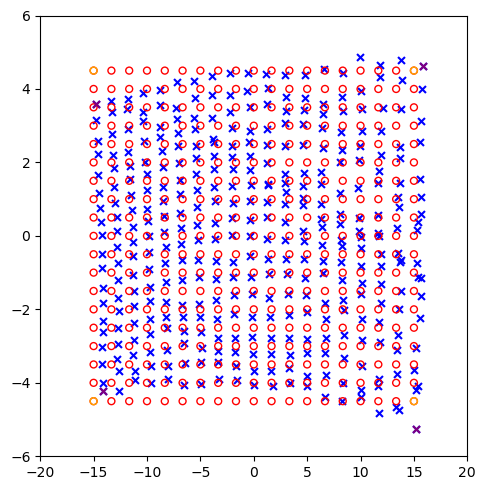

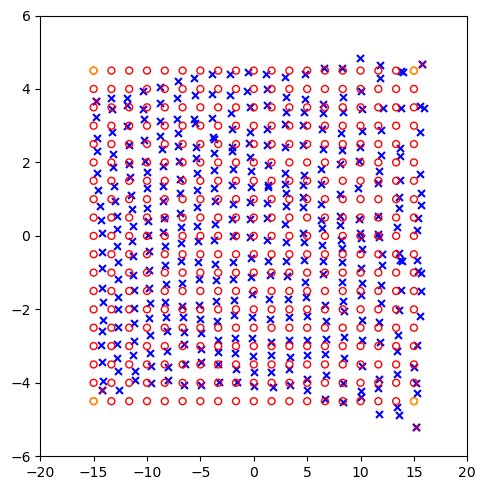

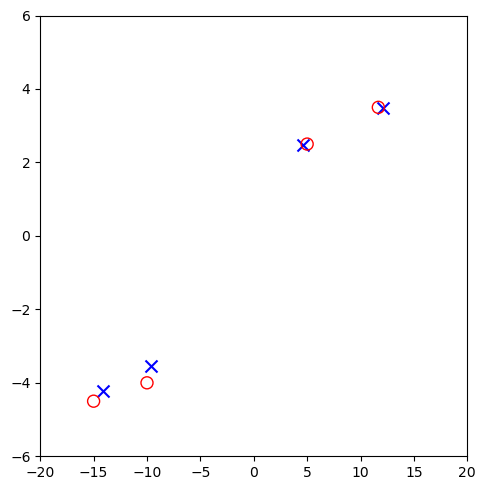

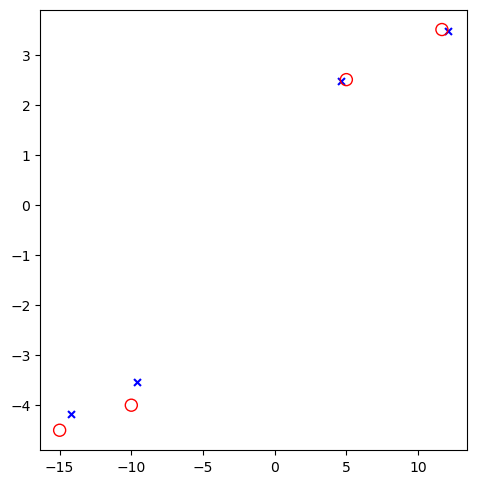

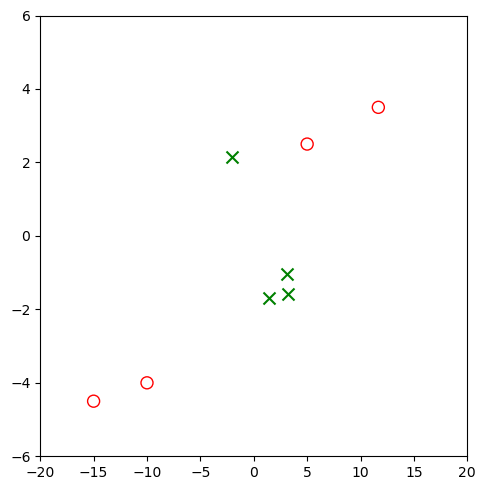

In [13]:
def repostition_grid(hat, target, corner_indices, CORNERS=True, Save=False):
    #plt.close()
    hat_corners=hat[corner_indices]
    targ_corners=target[[0, 18, 342,360]]
    
    if CORNERS:
        targ_translation=np.mean(targ_corners, axis=0)
        targ_scale=LA.norm(targ_corners-targ_translation, ord='fro')


        hat_translation=np.mean(hat_corners, axis=0)
        hat_scale=LA.norm(hat_corners-hat_translation, ord='fro')
    else:
        targ_translation=np.mean(target, axis=0)
        targ_scale=LA.norm(target-targ_translation, ord='fro')
        hat_translation=np.mean(hat, axis=0)
        hat_scale=LA.norm(hat-hat_translation, ord='fro')

    

    

    targ_standardized=(target-targ_translation)/targ_scale
    hat_standardized=(hat-hat_translation)/hat_scale

    targ_corners=targ_standardized[[0, 18, 342,360]]
    hat_corners=hat_standardized[corner_indices]
#    print(f'the column means are: {np.mean(targ_standardized, axis=0)}')

    result = generic(hat_corners, targ_corners, scale=False, translate=False)

    transformation=result.t
    x_scale=min(abs(targ_corners[:,0]))
    trans_2=np.array([[1.2,0],[0,1/2.5]])
    
    new_grid=(hat_standardized@transformation)*targ_scale#+targ_translation
    fig, ax = plt.subplots(figsize=(5,5))
    
    plt.tight_layout()
    plt.scatter(new_grid[:,0], new_grid[:,1], c='b', label='grid hat', s=25,marker='x')
    plt.scatter(target[:,0], target[:,1], facecolors='none', edgecolors='r', label='grid target', s=25)

    plt.scatter(target[[0,18,342,360],0], target[[0,18,342,360],1], edgecolors='orange', facecolors='none', s=25)

    plt.scatter(new_grid[corner_indices,0], new_grid[corner_indices,1], c='purple',s=25, marker='x')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xticks(ticks=x_list,fontsize=10)
    plt.yticks(ticks=y_list,fontsize=10)
    plt.axis([x_list[0],x_list[-1], y_list[0], y_list[-1]])
    if Save:
        plt.savefig('/home/achristie/Codes_data/Experiment_data/library_learning/single_medium_MDS.pdf')

    return new_grid
    



    

y = np.linspace(-15, 15, 19)
x = np.linspace(-4.50, 4.5, 19)
yv, xv = np.meshgrid(x, y)
#plt.scatter(xv, yv, label='True grid')
target_grid=np.zeros((19*19, 2))
target_grid[:,0]=xv.flatten()
target_grid[:,1]=yv.flatten()


New_grid=repostition_grid(single, target_grid, single_true_labeling[[0, 18, 342,360]], CORNERS=False, Save=True)
error=LA.norm(New_grid[single_true_labeling]-target_grid, ord='fro')/len(New_grid)
print(f'Error from grid recon using perf grid {error}')


True_corners=[0, 18, 342,360]


Estimated_corners_indices=np.abs((np.abs(np.inner(medium1[True_corners],medium_hat.conj()))))
Estimated_corners_indices_=[np.argmax(Estimated_corners_indices[i,:]) for i in range(4)] 
Estimated_corners_indices_=np.array(Estimated_corners_indices_)
Estimated_corners_indices_=single_estimated_true_lab[Estimated_corners_indices_]






New_grid_estimated=repostition_grid(single_estimated, target_grid, Estimated_corners_indices_, CORNERS=False)






Estimated_corners_indices=np.abs((np.abs(np.inner(medium1,medium_hat.conj()))))
Estimated_corners_indices_=[np.argmax(Estimated_corners_indices[i,:]) for i in range(361)] 
Estimated_corners_indices_=np.array(Estimated_corners_indices_)
Estimated_corners_indices_=single_estimated_true_lab[Estimated_corners_indices_]



error=LA.norm(New_grid_estimated[Estimated_corners_indices_]-target_grid, ord='fro')/len(New_grid_estimated)

print(f'Error from grid recon using imperfect grid {error}')
locat=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
















test_rho, test_b=H.Generate_data_pnas(locat, 1,S=4, seed=50,pixels='Gaussian_abs')





S=3
test_rho=np.zeros((1,medium.shape[-1]))

medium=medium1.T
if pixels=='Gaussian_abs':
    data_rho=np.zeros((1,medium.shape[-1]))+1j*np.zeros((1,medium.shape[-1]))

for i in range(1):

    data_rho[i][:S]=(1+np.abs(np.random.randn(S)))+1j*np.abs(np.random.randn(S))
    data_rho[i][:S]=data_rho[i][:S]/abs(data_rho[i][:S])
    
        #data_rho[i]=abs(data_rho[i])/sum(abs(data_rho[i]))
    perm = np.random.permutation(medium.shape[-1])
    data_rho[i]=data_rho[i][perm]
    data_rho[0][0]=(1+np.abs(np.random.randn(1)))+1j*np.abs(np.random.randn(1))
test_b=medium@data_rho.T

test_rho=data_rho
test_b=test_b.T




print(medium1.shape)
print(f'rho, b shape: {test_rho.shape}, {test_b.shape}')
permutation=np.argsort(single_true_labeling)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T

mixed_medium_1=medium1[permutation]

rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T

NUM_Points_gridified=100
grid_offset = np.array([x_list[0], y_list[0]])
grid_spacing = np.array([(x_list[-1]-x_list[0])/NUM_Points_gridified, (y_list[-1]-y_list[0])/NUM_Points_gridified])
gpoints_ = grid_offset + np.round((New_grid - grid_offset) / grid_spacing) * grid_spacing





x_y_coord_hat=New_grid[(abs(rho_hat_groundtruth).T)[0]>.9]
x_y_coord_rho=target_grid[(abs(test_rho))[0]>.9]
print(np.sort(abs(rho_hat_groundtruth).T)[0][-6:])



fig, ax = plt.subplots(figsize=(5,5))
plt.tight_layout()
plt.scatter(x_y_coord_hat[:,0], x_y_coord_hat[:,1], c='b', label='estimate', s=75,marker='x')


plt.scatter(x_y_coord_rho[:,0], x_y_coord_rho[:,1], facecolors='none', edgecolors='r', label='target', s=75)
#plt.legend()


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(ticks=x_list,fontsize=10)
plt.yticks(ticks=y_list,fontsize=10)
plt.axis([x_list[0],x_list[-1], y_list[0], y_list[-1]])

plt.savefig('/home/achristie/Codes_data/Experiment_data/library_learning/med1image_1dictionary.pdf')




permutation=np.argsort(single_estimated_true_lab)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T


mixed_medium_1=medium_hat[permutation]

rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
x_y_coord_hat=New_grid_estimated[np.argsort((abs(rho_hat_groundtruth).T)[0])[-4:]]
print(np.sort(abs(rho_hat_groundtruth).T)[0][-6:])





x_y_coord_rho=target_grid[(abs(test_rho))[0]>.7]
fig, ax = plt.subplots(figsize=(5,5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.scatter(x_y_coord_hat[:,0], x_y_coord_hat[:,1], c='b', label='estimate', s=25,marker='x')


plt.scatter(x_y_coord_rho[:,0], x_y_coord_rho[:,1], facecolors='none', edgecolors='r', label='target', s=75)
#plt.legend()








permutation=np.argsort(single_true_labeling)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
test_b=medium2@data_rho.T  #B IS TAKEN FROM MED 2
test_rho=data_rho
test_b=test_b.T



medium1=medium1.T
medium2=medium2.T
mixed_medium_1=medium1[permutation]  #PSUEDO TAKEN WITH MED1

rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
x_y_coord_hat=New_grid[np.argsort((abs(rho_hat_groundtruth).T)[0])[-4:]]
print(np.sort(abs(rho_hat_groundtruth).T)[0][-6:])
x_y_coord_rho=target_grid[(abs(test_rho))[0]>.9]



fig, ax = plt.subplots(figsize=(5,5))
plt.tight_layout()
plt.scatter(x_y_coord_hat[:,0], x_y_coord_hat[:,1], c='g', label='estimate', s=75,marker='x')


plt.scatter(x_y_coord_rho[:,0], x_y_coord_rho[:,1], facecolors='none', edgecolors='r', label='target', s=75)



plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(ticks=x_list,fontsize=10)
plt.yticks(ticks=y_list,fontsize=10)
plt.axis([x_list[0],x_list[-1], y_list[0], y_list[-1]])

plt.savefig('/home/achristie/Codes_data/Experiment_data/library_learning/med2image_1dictionary.pdf')
print(np.sort((abs(rho_hat_groundtruth).T)[0])[-6:]) 

(361, 806)
rho, b shape: (1, 361), (1, 806)


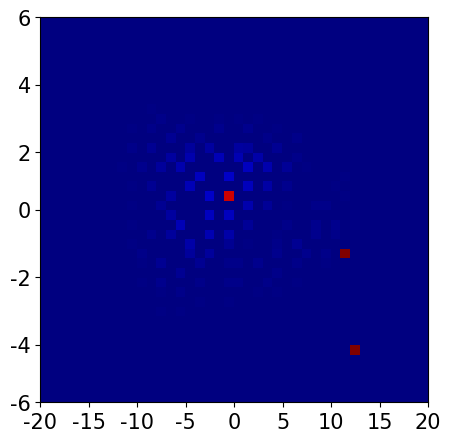

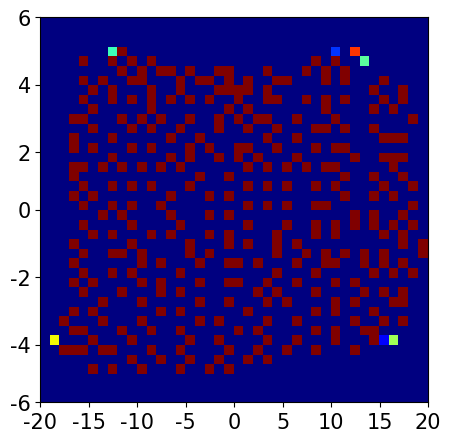

In [374]:
#IMAGES OF INNER PRODUCTS ACROSS 2 different random media
def plot_2_imgs(rho_hat,rho, ind=9,figsize=8,font_size=50,  xpix=31, ypix=21, file_name=None, Lclim=None, Hclim=None):
    plt.close()
    rho_hat_1=torch.tensor(rho_hat)

    rho=torch.tensor(rho)




    figsize=(figsize,figsize)
    fig, axes=plt.subplots(figsize=figsize)
    rhos=[rho_hat_1,rho]
    for i in [0]:
        rho_hat=rhos[i]
        tick_params = {'labelsize': font_size}
        output=rho_hat.squeeze() 
        output=output[ind,:]
        img=torch.abs((output.squeeze())).view(xpix, ypix)
        ax=axes
        pcol2=ax.pcolor(img.detach().cpu(),cmap='jet')
        cbar=plt.colorbar(pcol2, ax=ax)
    #plt.title('true', fontsize=font_size)
        #ax.set_title('Full model', fontsize=font_size)
        cbar.mappable.set_clim(Lclim, Hclim)
        
        cbar.ax.tick_params(labelsize=font_size)

        #cbar.remove()
        xtick_locats= np.linspace(0, NUM_Points_gridified, len(x_list), dtype=int)
        ytick_locats= np.linspace(0, NUM_Points_gridified, len(y_list), dtype=int)

        ax.tick_params(axis='both', **tick_params)
        ax.set_xticks( ticks=xtick_locats,labels=x_list, minor=False)#, font_size=font_size)
        ax.set_yticks( ticks=ytick_locats, labels=y_list, minor=False)#, font_size=font_size)
        
        #if i==0:
        cbar.remove()
    if file_name is not None:
        plt.savefig(file_name)
    plt.show()
NUM_Points_gridified=40
grid_offset = np.array([x_list[0], y_list[0]])
grid_spacing = np.array([(x_list[-1]-x_list[0])/NUM_Points_gridified, (y_list[-1]-y_list[0])/NUM_Points_gridified])
gpoint_indices =np.round((New_grid - grid_offset) / grid_spacing) 
gpoint_indices=gpoint_indices[:,0]*NUM_Points_gridified+gpoint_indices[:,1]
gpoint_indices=gpoint_indices.astype(int)


rho_hat=torch.zeros((2, NUM_Points_gridified*NUM_Points_gridified))


S=3
test_rho=np.zeros((1,medium.shape[-1]))

medium=medium1.T
if pixels=='Gaussian_abs':
    data_rho=np.zeros((1,medium.shape[-1]))+1j*np.zeros((1,medium.shape[-1]))

for i in range(1):
    data_rho[i][10*19+10-2]=1+1j*0
    data_rho[i][10*1+10-5]=1+1j*0
    data_rho[i][10*11+10+8]=1+1j*0
test_b=medium@data_rho.T  #b taken from medium1

test_rho=data_rho
test_b=test_b.T




print(medium1.shape)
print(f'rho, b shape: {test_rho.shape}, {test_b.shape}')
permutation=np.argsort(single_true_labeling)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T

mixed_medium_1=medium1[permutation]

rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
#rho_hat_groundtruth=mixed_medium_1.conj()@test_b.T #KM done with medium1 

rho_hat=np.zeros((2, NUM_Points_gridified*NUM_Points_gridified))
rho_hat[0, gpoint_indices]=np.abs(rho_hat_groundtruth).T


rho=np.zeros((2, NUM_Points_gridified*NUM_Points_gridified))
gpoint_indices =np.round((target_grid - grid_offset) / grid_spacing) 
gpoint_indices=gpoint_indices[:,0]*NUM_Points_gridified+gpoint_indices[:,1]
gpoint_indices=gpoint_indices.astype(int)


rho[0, gpoint_indices]=np.abs(test_rho)





permutation=np.argsort(single_true_labeling)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
test_b=medium2@data_rho.T   #b taken from medium2
test_rho=data_rho
test_b=test_b.T



medium1=medium1.T
medium2=medium2.T




mixed_medium_1=medium1[permutation]    #KM done with medium1
gpoint_indices =np.round((New_grid - grid_offset) / grid_spacing) 
gpoint_indices=gpoint_indices[:,0]*NUM_Points_gridified+gpoint_indices[:,1]
gpoint_indices=gpoint_indices.astype(int)


rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
#rho_hat_groundtruth=mixed_medium_1.conj()@test_b.T

rho_hat_med_2=np.zeros((2, NUM_Points_gridified*NUM_Points_gridified))
rho_hat_med_2[0, gpoint_indices]=np.abs(rho_hat_groundtruth).T

#rho_hat[0, :]=inners[J,:361]
#rho=torch.tensor(rho)
#rho_hat=torch.tensor(rho_hat)
plot_2_imgs(rho_hat, rho_hat_med_2,ind=0, figsize=5,  xpix=NUM_Points_gridified, ypix=NUM_Points_gridified, font_size=15, file_name='/home/achristie/Codes_data/Experiment_data/library_learning/med1image_1dictionary.pdf',Lclim=0, Hclim=1)
#rho_hat=np.zeros((2, 361))
plot_2_imgs(rho_hat_med_2, rho_hat,ind=0, figsize=5,  xpix=NUM_Points_gridified, ypix=NUM_Points_gridified, font_size=15, file_name='/home/achristie/Codes_data/Experiment_data/library_learning/med2image_1dictionary.pdf',Lclim=0, Hclim=1)


(361, 806)
rho, b shape: (1, 361), (1, 806)


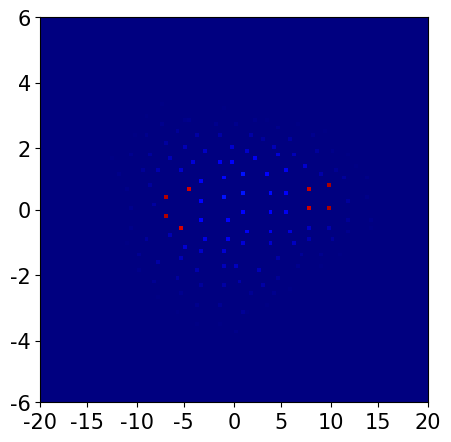

In [379]:
#IMAGES OF INNER PRODUCTS ACROSS 2 different random media

NUM_Points_gridified=19
grid_offset = np.array([x_list[0], y_list[0]])
grid_spacing = np.array([(x_list[-1]-x_list[0])/NUM_Points_gridified, (y_list[-1]-y_list[0])/NUM_Points_gridified])
gpoint_indices =np.round((New_grid - grid_offset) / grid_spacing) 
gpoint_indices=gpoint_indices[:,0]*NUM_Points_gridified+gpoint_indices[:,1]
gpoint_indices=gpoint_indices.astype(int)


rho_hat=torch.zeros((2, NUM_Points_gridified*NUM_Points_gridified))


test_rho=np.zeros((1,medium.shape[-1]))

medium=medium1.T
data_rho=np.zeros((1,medium.shape[-1]))+1j*np.zeros((1,medium.shape[-1]))

for i in range(1):
    data_rho[i][13+19*9]=1+1j*0
    data_rho[i][13+19*10]=1+1j*0
    data_rho[i][12+19*9]=1+1j*0
    data_rho[i][12+19*10]=1+1j*0



    data_rho[i][6+19*9]=1+1j*0
    data_rho[i][6+19*10]=1+1j*0
    data_rho[i][5+19*9]=1+1j*0
    data_rho[i][5+19*10]=1+1j*0

    #data_rho[i][12*19+10-3]=1+1j*0
    
    #data_rho[i][13*19+10-3]=1+1j*0

    #data_rho[i][10*19+10-4]=1+1j*0

    #data_rho[i][10*19+10-2]=1+1j*0

    #data_rho[i][12*19+10-3]=1+1j*0
    #data_rho[i][12*19+10-4]=1+1j*0
    #data_rho[i][12*19+10-2]=1+1j*0

    #data_rho[i][9*19+10-3]=1+1j*0
    #data_rho[i][9*19+10-4]=1+1j*0
    #data_rho[i][9*19+10-2]=1+1j*0


    #data_rho[i][10*1+10-5]=1+1j*0
    #data_rho[i][10*11+10+8]=1+1j*0
    
test_b=medium@data_rho.T  #b taken from medium1

test_rho=data_rho
test_b=test_b.T




print(medium1.shape)
print(f'rho, b shape: {test_rho.shape}, {test_b.shape}')
permutation=np.argsort(single_true_labeling)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T
medium2=medium2.T
mixed_medium_1=medium1[permutation]






#med1 med1
rho_groundtruth_1med=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
rho_groundtruth_1med_KM=mixed_medium_1.conj()@test_b.T #KM done with medium1 

#med1hat med1
permutation=np.argsort(single_estimated_true_lab)
mixed_medium_1=medium_hat[permutation]
rho_hat_1sensing=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
rho_hat_1sensing_KM=mixed_medium_1.conj()@test_b.T 

#med1 med2
permutation=np.argsort(single_true_labeling)
mixed_medium_1=medium2[permutation]
rho_hat_1sensing_MED2=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
rho_hat_1sensing_MED2_KM=mixed_medium_1.conj()@test_b.T 


#double medium true
permutation=np.argsort(double_true_labeleing)
mixed_medium_1=medium[permutation]
rho_groundtruth_2med=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
rho_groundtruth_2med_KM=mixed_medium_1.conj()@test_b.T


#double medium estimated
permutation=np.argsort(double_estimated_true_lab)
mixed_medium_1=medium_hat_double[permutation]
rho_hat_2sensing=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
rho_hat_2sensing_KM=mixed_medium_1.conj()@test_b.T





def snap_plot(rho_hat,rho, ind=9,figsize=8,font_size=50, NUM_Points_gridified=40, file_name=None, Lclim=None, Hclim=None,New_grid=None):
    plt.close()
    xpix=NUM_Points_gridified
    ypix=NUM_Points_gridified

    rho=np.zeros((2, NUM_Points_gridified*NUM_Points_gridified))


    
    grid_offset = np.array([x_list[0], y_list[0]])
    grid_spacing = np.array([(x_list[-1]-x_list[0])/NUM_Points_gridified, (y_list[-1]-y_list[0])/NUM_Points_gridified])
    gpoint_indices =np.round((New_grid - grid_offset) / grid_spacing) 
    gpoint_indices=gpoint_indices[:,0]*NUM_Points_gridified+gpoint_indices[:,1]
    gpoint_indices=gpoint_indices.astype(int)
    rho[0, gpoint_indices]=np.abs(rho_hat).T





    rho_hat_1=torch.tensor(rho)

    rho=torch.tensor(rho)




    figsize=(figsize,figsize)
    fig, axes=plt.subplots(figsize=figsize)
    rhos=[rho_hat_1,rho]
    for i in [0]:
        rho_hat=rhos[i]
        tick_params = {'labelsize': font_size}
        output=rho_hat.squeeze() 
        output=output[ind,:]
        img=torch.abs((output.squeeze())).view(xpix, ypix)
        ax=axes
        pcol2=ax.pcolor(img.detach().cpu(),cmap='jet')
        cbar=plt.colorbar(pcol2, ax=ax)
    #plt.title('true', fontsize=font_size)
        #ax.set_title('Full model', fontsize=font_size)
        cbar.mappable.set_clim(Lclim, Hclim)
        
        cbar.ax.tick_params(labelsize=font_size)

        #cbar.remove()
        xtick_locats= np.linspace(0, NUM_Points_gridified, len(x_list), dtype=int)
        ytick_locats= np.linspace(0, NUM_Points_gridified, len(y_list), dtype=int)

        ax.tick_params(axis='both', **tick_params)
        ax.set_xticks( ticks=xtick_locats,labels=x_list, minor=False)#, font_size=font_size)
        ax.set_yticks( ticks=ytick_locats, labels=y_list, minor=False)#, font_size=font_size)
        
        #if i==0:
        cbar.remove()
    if file_name is not None:
        plt.savefig(file_name)
    plt.show()





NUM_Points_gridified=100
snap_plot(rho_groundtruth_1med, rho_hat_med_2,ind=0, figsize=5,  NUM_Points_gridified=NUM_Points_gridified, font_size=15,Lclim=0, Hclim=1,New_grid=New_grid)
#snap_plot(rho_hat_1sensing_MED2, rho_hat_med_2,ind=0, figsize=5,  NUM_Points_gridified=NUM_Points_gridified, font_size=15,Lclim=0, Hclim=1,New_grid=New_grid)
#snap_plot(rho_hat_1sensing, rho_hat_med_2,ind=0, figsize=5,  NUM_Points_gridified=NUM_Points_gridified, font_size=15,Lclim=0, Hclim=1,New_grid=New_grid_estimated)


#snap_plot(rho_groundtruth_2med, rho_hat_med_2,ind=0, figsize=5,  NUM_Points_gridified=NUM_Points_gridified, font_size=15,Lclim=0, Hclim=1,New_grid=New_grid_double_TRUE)
#snap_plot(rho_hat_2sensing, rho_hat_med_2,ind=0, figsize=5,  NUM_Points_gridified=NUM_Points_gridified, font_size=15,Lclim=0, Hclim=1,New_grid=New_grid_double_estimated)

#rho_hat=np.zeros((2, 361))
#plot_2_imgs(rho_hat_med_2, rho_hat,ind=0, figsize=5,  xpix=NUM_Points_gridified, ypix=NUM_Points_gridified, font_size=15, file_name='/home/achristie/Codes_data/Experiment_data/library_learning/med2image_1dictionary.pdf',Lclim=0, Hclim=1)


In [266]:
target_grid[54]

array([11.66666667, -3.5       ])

In [252]:
Xi.shape

(100, 100)

(361,)


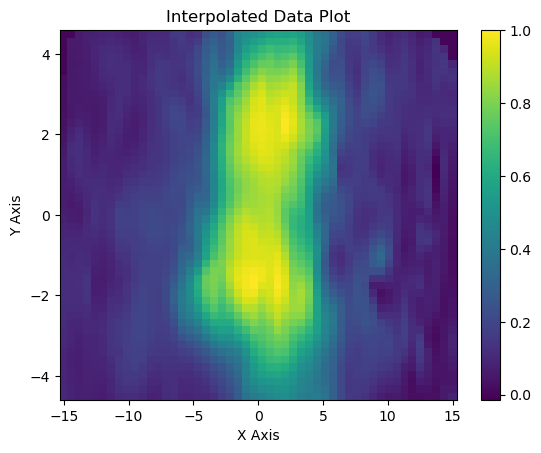

In [382]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Assume xnorm, znorm, xr, zr, and IM_KM_m_ri are already defined as numpy arrays
# Creating the regular grid
def interpole_Fig(rho, grid):
    plt.close()




   





    x = np.linspace(-15, 15, 50)
    y = np.linspace(-4.50, 4.5, 50)
    Xi, Yi = np.meshgrid(x, y)


    xr=grid[:,0]
    zr=grid[:,1]
    IM_KM_m_ri=np.abs(rho).T[0]
    print(IM_KM_m_ri.shape)
    # Performing the interpolation using cubic method
    z1 = griddata((xr, zr), IM_KM_m_ri, (Xi, Yi), method='cubic', fill_value=0)
    # Plotting the result
    plt.pcolor(Xi, Yi, z1/ np.max(z1))
    plt.colorbar()  # Optional: adds a color bar to the plot
    # Plotting the result
    #plt.colorbar()  # Optional: adds a color bar to the plot
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title('Interpolated Data Plot')
    plt.show()
interpole_Fig(rho_groundtruth_1med_KM, New_grid)


(361, 1) (1, 806)


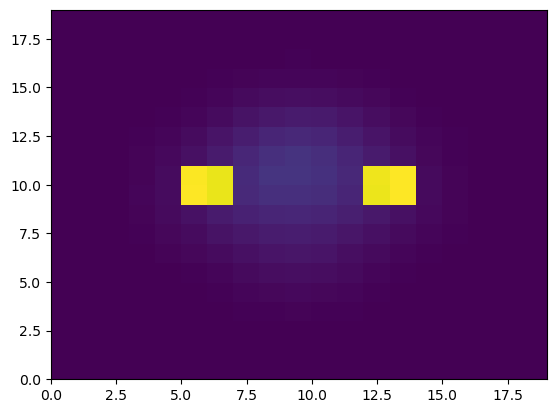

In [383]:


data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium1=medium1.T

fuck=np.linalg.pinv(medium1.conj()@medium1.T)@medium1.conj()@test_b.T#medium1.conj()@test_b.T #KM done with medium1 
print(fuck.shape, test_b.shape)
plt.pcolor(np.abs(fuck).reshape(19,19))


(361, 806) (1, 361)
(361, 1) (1, 806)


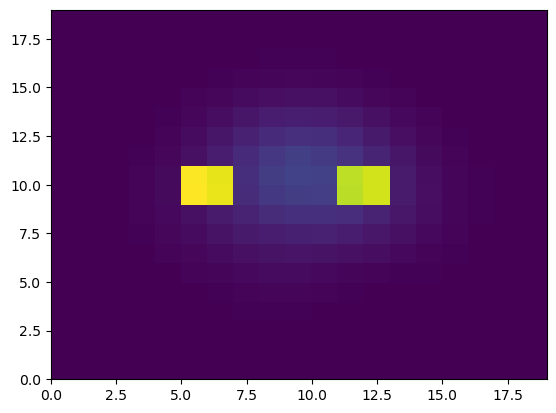

In [378]:
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium1=medium1.T
data_rho=np.zeros((1,medium1.shape[-2]))+1j*np.zeros((1,medium1.shape[-2]))

for i in range(1):
    data_rho[i][11+19*9]=1+1j*0
    data_rho[i][11+19*10]=1+1j*0
    data_rho[i][12+19*9]=1+1j*0
    data_rho[i][12+19*10]=1+1j*0



    data_rho[i][6+19*9]=1+1j*0
    data_rho[i][6+19*10]=1+1j*0
    data_rho[i][5+19*9]=1+1j*0
    data_rho[i][5+19*10]=1+1j*0


print(medium1.shape,data_rho.shape)
fuck=np.linalg.pinv(medium1.conj()@medium1.T)@medium1.conj()@(medium1.T@data_rho.T)#medium1.conj()@test_b.T #KM done with medium1 
print(fuck.shape, test_b.shape)
plt.pcolor(np.abs(fuck).reshape(19,19))


(806, 361) (361, 2)
(361, 806) (806, 2)
(361, 1) (806, 2)


/tmp/ipykernel_581099/1438666504.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rho=torch.tensor(rho)


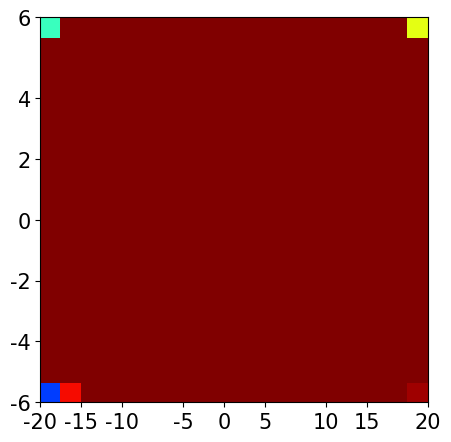

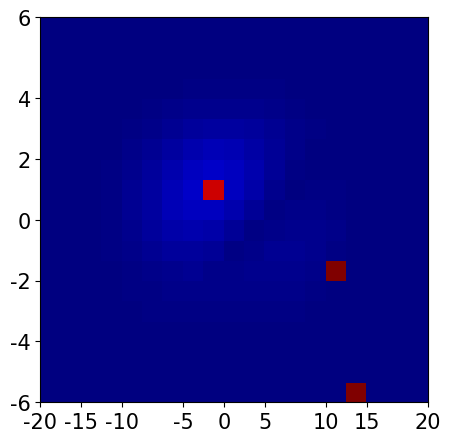

In [231]:


S=3
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
test_rho=np.zeros((1,medium1.shape[-1]))

if pixels=='Gaussian_abs':
    data_rho=np.zeros((2,medium1.shape[-1]))+1j*np.zeros((2,medium1.shape[-1]))

for i in range(1):

    data_rho[i][10*19+10-2]=1+1j*0
    data_rho[i][10*1+10-5]=1+1j*0
    data_rho[i][10*11+10+8]=1+1j*0





data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)


test_rho=data_rho


print(medium1.shape, data_rho.T.shape)
test_b=(medium1@data_rho.T)


test_b=test_b.T
medium1=medium1.T
medium2=medium2.T
print(medium1.shape, test_b.T.shape)
mixed_medium_1=medium2
#mixed_medium_1[10*19+10-2]=medium2[10*19+10-2]
print(rho_hat_groundtruth.shape, test_b.T.shape)

rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
#rho_hat_groundtruth=mixed_medium_1.conj()@test_b.T


plot_2_imgs(rho_hat_groundtruth.T, rho_hat,ind=0, figsize=5,  xpix=19, ypix=19, font_size=15, Lclim=0, Hclim=1)
rho_hat_groundtruth=np.linalg.pinv(medium1.conj()@medium1.T)@medium1.conj()@test_b.T

#rho_hat_groundtruth=medium1.conj()@test_b.T
plot_2_imgs(rho_hat_groundtruth.T, rho_hat,ind=0, figsize=5,  xpix=19, ypix=19, font_size=15, Lclim=0, Hclim=1)



Error from grid1 recon using perf grid 0.055414729040698225 and error from grid2 recon using perf grid 0.05668259673535651
(722, 806) (721, 806)


IndexError: index 649 is out of bounds for axis 0 with size 361

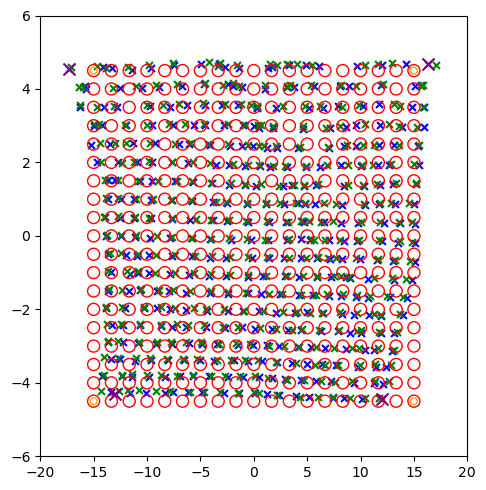

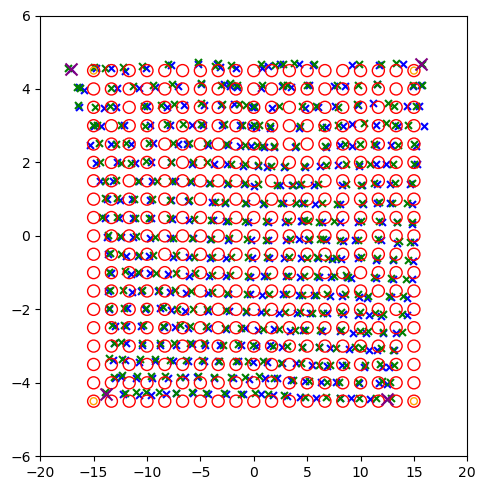

In [14]:
def repostition_grid_2med(hat, target, True_labeleing, CORNERS=True, Save=False):
    corner_indices=True_labeleing[[0, 18, 342,360]]
    hat_corners=hat[corner_indices]
    targ_corners=target[[0, 18, 342,360]]


    
    
    if CORNERS:
        targ_translation=np.mean(targ_corners, axis=0)
        targ_scale=LA.norm(targ_corners-targ_translation, ord='fro')


        hat_translation=np.mean(hat_corners, axis=0)
        hat_scale=LA.norm(hat_corners-hat_translation, ord='fro')
    else:
        targ_translation=np.mean(target, axis=0)
        targ_scale=LA.norm(target-targ_translation, ord='fro')
        hat_translation=np.mean(hat, axis=0)
        hat_scale=LA.norm(hat-hat_translation, ord='fro')

    

    

    targ_standardized=(target-targ_translation)/targ_scale
    hat_standardized=(hat-hat_translation)/hat_scale

    targ_corners=targ_standardized[[0, 18, 342,360]]
    hat_corners=hat_standardized[corner_indices]
#    print(f'the column means are: {np.mean(targ_standardized, axis=0)}')

    result = generic(hat_corners, targ_corners, scale=False, translate=False)

    transformation=result.t
    x_scale=min(abs(targ_corners[:,0]))
    trans_2=np.array([[1.2,0],[0,1/2.5]])
    
    new_grid=(hat_standardized@transformation)*targ_scale#+targ_translation
    fig, ax = plt.subplots(figsize=(5,5))
    plt.tight_layout()
    
    plt.scatter(new_grid[True_labeleing[:361],0], new_grid[True_labeleing[:361],1], c='b', label='grid hat', s=25,marker='x')
    plt.scatter(new_grid[True_labeleing[361:],0], new_grid[True_labeleing[361:],1], c='g', label='grid hat', s=25,marker='x')

    plt.scatter(target[:,0], target[:,1], facecolors='none', edgecolors='r', label='grid target', s=75)
    
    plt.scatter(target[[0,18,342,360],0], target[[0,18,342,360],1], edgecolors='orange', facecolors='none', s=25)

    plt.scatter(new_grid[corner_indices,0], new_grid[corner_indices,1], c='purple',s=75, marker='x')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xticks(ticks=x_list,fontsize=10)
    plt.yticks(ticks=y_list,fontsize=10)
    plt.axis([x_list[0],x_list[-1], y_list[0], y_list[-1]])
    if Save:
        plt.savefig('/home/achristie/Codes_data/Experiment_data/library_learning/double_medium_MDS.pdf')

    return new_grid
    


    

x = np.linspace(-15, 15, 19)
y = np.linspace(-4.50, 4.5, 19)
xv, yv = np.meshgrid(x, y)
target_grid=np.zeros((19*19, 2))
target_grid[:,0]=xv.flatten()
target_grid[:,1]=yv.flatten()


New_grid_double_TRUE=repostition_grid_2med(double, target_grid, double_true_labeleing, CORNERS=False, Save=True)

error_1=LA.norm(New_grid_double_TRUE[double_true_labeleing][:361]-target_grid, ord='fro')/(len(New_grid_double_TRUE)/2)
error_2=LA.norm(New_grid_double_TRUE[double_true_labeleing][361:]-target_grid, ord='fro')/(len(New_grid_double_TRUE)/2)








print(f'Error from grid1 recon using perf grid {error_1} and error from grid2 recon using perf grid {error_2}')


True_corners=[0, 18, 342,360]

print(col_list.shape, medium_hat_double.shape)

Estimated_corners_indices=np.abs((np.abs(np.inner(col_list,medium_hat_double.conj()))))
Estimated_corners_indices_=[np.argmax(Estimated_corners_indices[i,:]) for i in range(722)] 
Estimated_corners_indices_=np.array(Estimated_corners_indices_)
Estimated_corners_indices_=double_estimated_true_lab[Estimated_corners_indices_]


New_grid_double_estimated=repostition_grid_2med(double_estimated, target_grid, Estimated_corners_indices_, CORNERS=False)





error_1_est=LA.norm(New_grid_estimated[Estimated_corners_indices_][:361]-target_grid, ord='fro')/(len(New_grid_double_estimated)/2)
error_2_est=LA.norm(New_grid_estimated[Estimated_corners_indices_][361:]-target_grid, ord='fro')/(len(New_grid_double_estimated)/2)








print(f'Error from grid1 recon using imperfect grid {error_1_est} and error from grid2 recon using perf grid {error_2_est}')






test_b=medium1.T@data_rho.T
test_rho=data_rho
test_b=test_b.T


permutation=np.argsort(double_true_labeleing)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T


mixed_medium_1=medium[permutation]

rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
x_y_coord_hat=New_grid_double_estimated[np.argsort((abs(rho_hat_groundtruth).T)[0])[-4:]]






x_y_coord_rho=target_grid[(abs(test_rho))[0]>.7]
fig, ax = plt.subplots(figsize=(5,5))
plt.tight_layout()
plt.scatter(x_y_coord_hat[:,0], x_y_coord_hat[:,1], c='b', label='estimate', s=75,marker='x')


plt.scatter(x_y_coord_rho[:,0], x_y_coord_rho[:,1], facecolors='none', edgecolors='r', label='target', s=75)
#plt.legend()

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(ticks=x_list,fontsize=10)
plt.yticks(ticks=y_list,fontsize=10)
plt.axis([x_list[0],x_list[-1], y_list[0], y_list[-1]])

plt.savefig('/home/achristie/Codes_data/Experiment_data/library_learning/med1image_2dictionary.pdf')





test_b=medium2@data_rho.T
test_rho=data_rho
test_b=test_b.T
permutation=np.argsort(double_true_labeleing)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium1=medium1.T
mixed_medium_1=medium[permutation]
rho_hat_groundtruth=np.linalg.pinv(mixed_medium_1.conj()@mixed_medium_1.T)@mixed_medium_1.conj()@test_b.T
x_y_coord_hat=New_grid_double_estimated[np.argsort((abs(rho_hat_groundtruth).T)[0])[-4:]]
x_y_coord_rho=target_grid[(abs(test_rho))[0]>.7]




fig, ax = plt.subplots(figsize=(5,5))




#ax.set_xticks(ticks=x_list, minor=False)#, font_size=font_size)
#ax.set_yticks(ticks=y_list,minor=False)#, font_size=font_size)
    #ax.set_xticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
    #ax.set_yticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)

plt.tight_layout()
plt.scatter(x_y_coord_hat[:,0], x_y_coord_hat[:,1], c='g', label='estimate', s=75,marker='x')
plt.scatter(x_y_coord_rho[:,0], x_y_coord_rho[:,1], facecolors='none', edgecolors='r', label='target', s=75)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(ticks=x_list,fontsize=10)
plt.yticks(ticks=y_list,fontsize=10)
plt.axis([x_list[0],x_list[-1], y_list[0], y_list[-1]])

plt.savefig('/home/achristie/Codes_data/Experiment_data/library_learning/med2image_2dictionary.pdf')
#plt.legend()


In [37]:
(error_1_est+error_2_est)/2, (error_1+error_2)/2


(0.06005483237082343, 0.053723819024318886)

In [31]:
x_list

[-15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

In [39]:
LA.norm(New_grid-target_grid, ord='fro')/len(New_grid)

0.6875668286076716

In [30]:
LA.norm(New_grid[-target_grid, ord='fro')/len(New_grid)

0.6685397777680756

In [34]:
LA.norm(New_grid-target_grid, ord='fro')/len(New_grid)

0.6685397777680756

In [75]:
tester=False
if tester>=0:
    print(5)

5


(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (25600, 806), number for Expceriments: 70
(806,)


KeyboardInterrupt: 

(806, 722)
coherence of data:  0.763143828697641
Number of decoder used: 25
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (25600, 806), number for Expceriments: 70
(806,)
Number of recoverd: 721


In [14]:
medium_hat_double

NameError: name 'medium_hat_double' is not defined

In [46]:
medium1.shape, medium_hat.shape
inners=np.abs(np.inner(medium1, medium_hat.conj()))
inners=np.max(inners, axis=1)
len(inners[inners>.998])

361